![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Forecasting & Nowcasting HW1
Amber Walker and Mox Ballo


# Introduction

In this homework, we are aiming to predict the incidence of a peace agreement. We are integrating the text analysis from the conflict data discussed in class with the peace agreements data from the University of Edinburgh's PA-X database and the GDELT event database.

This project predicts the onset of peace agreements in conflict zones to aid timely and informed decision-making by international stakeholders.

Forecasting the onset of peace agreements using the aforementioned datasets allows tracking the initiation of peace processes across different countries and periods. This can be very useful to policymakers such as government officials, international organizations or even NGOs, which facilitate strategic planning and effective resource allocation in anticipation of peace processes.

## Housekeeping

In [1]:
# install external packages
!pip install panelsplit > /dev/null # installation of PanelSplit
!pip install wbdata > /dev/null # installation of wbdata
!pip install pycountry > /dev/null # contains country codes
!pip install optuna > /dev/null
!pip install shap > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 1.4.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [2]:
# import all relevant packages in the project
import os
import itertools
import re

# Data manipulation and computing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, auc, accuracy_score)
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import optuna

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
import shap

# External APIs and frameworks
import statsmodels.api as sm
import wbdata
import pycountry

# Google Colab specific
from google.colab import drive
drive.mount('/content/drive')

# Configure tqdm for pandas
tqdm.pandas()

Mounted at /content/drive


In [4]:
# file path directory
path= '/content/drive/Shareddrives/MasterProject'
spitout= '/content/drive/Shareddrives/MasterProject/02 Data/data'

# <a id='part0'>Part 0: Data Acquisition, Preprocessing, and Integration</a>


The target variable in this project is the incidence of a peace agreement in that period as listed in the PA-X database. In addition, data from GDELT was also obtained to capture the tone, frequency, and nature of media coverage globally, which provides valuable contextual information on the geopolitical environment and public sentiment surrounding potential peace processes. This enhances the model's ability to predict peace agreements by incorporating indicators of evolving political landscapes and international attention.



## GDELT Acquisition

In this project, instead of scraping the entirety of GDELT data which takes a lot of storage and RAM to run, we utilized Google's BigQuery to efficiently query and analyze specific, relevant data subsets. Our focus was on extracting data by using SQL queries to retrieve features such as country codes and the period of events. The queries were structured to not only count total events but also categorize them by governmental and oppositional involvement based on the actor codes in the dataset. Furthermore, we calculated the average Goldstein Scale, a measure of the potential impact of events on stability. This preprocessing within BigQuery allows for a streamlined analysis directly targeting variables critical to understanding the dynamics surrounding peace agreements, thereby enhancing the accuracy and relevance of our predictive models.

*Note that given BSE's limitation on accessing the BigQuery API, this portion was executed using our personal google accounts.*

In [ ]:
# def create_query_for_year(year):
    """
    Generate the SQL query for the entire year.
    """
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)

    query = f"""
    SELECT
        ActionGeo_ADM1Code,
        ActionGeo_CountryCode,
        EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING))) AS year,
        EXTRACT(MONTH FROM PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING))) AS month,
        COUNT(*) AS total_events,
        COUNTIF(Actor1Type1Code IN ('GOV', 'COP', 'MIL') OR Actor2Type1Code IN ('GOV', 'COP', 'MIL')) AS gov_related_events,
        COUNTIF(Actor1Type1Code IN ('INS', 'OPP', 'REB', 'SEP')) AS opp_related_events,
        AVG(GoldsteinScale) AS avg_goldstein_scale,  -- Calculating average Goldstein Scale without conditions
        AVG(CASE
            WHEN EventRootCode IS NOT NULL THEN GoldsteinScale
            ELSE NULL
        END) AS conditional_avg_goldstein_scale  -- Conditional average based on EventRootCode
    FROM
        `gdelt-bq.gdeltv2.events`
    WHERE
        SQLDATE BETWEEN {start_date.strftime('%Y%m%d')} AND {end_date.strftime('%Y%m%d')}
    GROUP BY
        ActionGeo_ADM1Code, ActionGeo_CountryCode, year, month
    """
    return query

In [ ]:
# # DataFrame to store all results
# df_all_years = pd.DataFrame()

# # Loop through each year from 1989 to 2023
# for year in range(1989, 2024):
#     query = create_query_for_year(year)
#     query_job = client.query(query)
#     df_year = query_job.result().to_dataframe()

#     # Append the yearly data to the main DataFrame
#     df_all_years = pd.concat([df_all_years, df_year], ignore_index=True)

# # Inspecting the combined DataFrame
# print(df_all_years.describe())

# filename = 'gdelt_sum.csv'
# file_path = os.path.join(spitout, filename)
# df_all_years = pd.read_csv(file_path)

Although we tried to obtain data from 1989 to present, the GDELT version available in BigQuery does not include the first version, which contains data earlier than 2005.

## GDELT Cleaning and Initial Preprocessing

Although the GDELT BigQuery was already summarized, some initial preprocessing and transformations were done for easier integration with the conflict data and the PA-X data.

In [ ]:
gdelt_raw = pd.read_csv(spitout + '/gdelt_sum.csv')
gdelt_p = gdelt_raw.dropna(subset=["ActionGeo_CountryCode"]) # drop null ActionGeo_CountryCode

### Convert ISO Codes

Since the GDELT data uses the FIPS 10-4 country codes, the country codes were converted to the ISO format using the `pycountry` package:

In [ ]:
def convert_alpha2_to_alpha3(alpha_2):
    try:
        # Ensure the input is a string and is not empty
        if isinstance(alpha_2, str) and alpha_2:
            country = pycountry.countries.get(alpha_2=alpha_2)
            return country.alpha_3 if country else None
        else:
            return None
    except Exception as e:
        print(f"Error converting code '{alpha_2}': {e}")
        return None


gdelt_p['iso_code'] = gdelt_raw['ActionGeo_CountryCode'].apply(convert_alpha2_to_alpha3)

<ipython-input-5-11f3816701cf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdelt_p['iso_code'] = gdelt_raw['ActionGeo_CountryCode'].apply(convert_alpha2_to_alpha3)


However, there are still some countrycodes that had to be manually fixed:

In [ ]:
# what are the null iso_codes?
fips_codes = ['EI', 'MI', 'VM', 'TI', 'TU', 'SF', 'SW', 'UK', 'ZI', 'JA', 'IZ',
              'SU', 'BU', 'RP', 'PP', 'TX', 'EZ', 'AJ', 'IC', 'OS', 'YM', 'SP',
              'LO', 'IV', 'WE', 'UP', 'DA', 'OD', 'RI', 'CS', 'WA', 'CE', 'UV',
              'RB', 'PO', 'KS', 'TS', 'KU', 'RQ', 'BC', 'LE', 'CJ', 'GZ', 'CB',
              'BX', 'AY', 'HA', 'GV', 'EN', 'MJ', 'CT', 'HO', 'DR', 'LH', 'NH',
              'OC', 'BK', 'PU', 'YI', 'EK', 'KV', 'GJ', 'LG', 'VQ', 'KT', 'PC',
              'VT', 'AA', 'BP', 'WI', 'GK', 'RM', 'TP', 'AC', 'WZ', 'MB', 'CQ',
              'FG', 'NS', 'RN', 'AN', 'AV', 'FP', 'NT', 'JN', 'TE', 'WQ', 'FQ',
              'KQ', 'JQ', 'HQ', 'LQ', 'IP', 'DQ', 'EU', 'GO', 'JU']

fips_to_iso3 = {
    'EI': 'IRL',  # Ireland
    'MI': 'MDV',  # Maldives
    'VM': 'VNM',  # Vietnam
    'TI': 'TJK',  # Tajikistan
    'TU': 'TUR',  # Turkey
    'SF': 'ZAF',  # South Africa
    'SW': 'SWE',  # Sweden
    'UK': 'GBR',  # United Kingdom
    'ZI': 'ZWE',  # Zimbabwe
    'JA': 'JPN',  # Japan
    'IZ': 'IRQ',  # Iraq
    'SU': 'RUS',   # Soviet Union,consider RU (Russia)
    'BU': 'BGR',  # Bulgaria
    'RP': 'PHL',  # Philippines
    'PP': 'PNG',  # Papua New Guinea
    'TX': 'TKM',  # Turkmenistan
    'EZ': 'CZE',  # Czech Republic
    'AJ': 'AZE',  # Azerbaijan
    'IC': 'ISL',  # Iceland
    'OS': 'SGS',  # South Georgia and the South Sandwich Islands
    'YM': 'YEM',  # Yemen
    'SP': 'ESP',  # Spain
    'LO': 'SVK',  # Slovakia
    'IV': 'CIV',  # Côte d'Ivoire
    'WE': 'PSE',  # Palestine
    'UP': 'UKR',  # Ukraine
    'DA': 'DNK',  # Denmark
    'OD': 'SDN',   # South Sudan
    'RI': 'IDN',  # Indonesia
    'CS': 'SRB',   # Serbia and Montenegro, consider SRB (Serbia)
    'WA': 'NAM',  # Namibia
    'CE': 'LKA',  # Sri Lanka
    'UV': 'BFA',  # Burkina Faso
    'RB': 'SRB',  # Serbia
    'PO': 'PRT',  # Portugal
    'KS': 'KOR',  # South Korea
    'TS': 'TUN',  # Tunisia
    'KU': 'KWT',  # Kuwait
    'RQ': 'PRI',  # Puerto Rico
    'BC': 'VGB',  # British Virgin Islands
    'LE': 'LBN',  # Lebanon
    'CJ': 'CYM',  # Cayman Islands
    'GZ': 'GZA',  # Gaza Strip
    'CB': 'KHM',  # Cambodia
    'BX': 'BRB',  # Barbados
    'AY': 'ATA',  # Antarctica
    'HA': 'HTI',  # Haiti
    'GV': 'GNB',  # Guinea-Bissau
    'EN': 'EST',  # Estonia
    'MJ': 'MNE',   # Montenegro
    'CT': 'CAF',  # Central African Republic
    'HO': 'HND',  # Honduras
    'DR': 'DOM',  # Dominican Republic
    'LH': 'LCA',  # Saint Lucia
    'NH': 'VUT',  # Vanuatu
    'OC': 'COK',  # Cook Islands
    'BK': 'BIH',  # Bosnia and Herzegovina
    'PU': 'PLW',  # Palau
    'YI': 'XXK',   # Kosovo
    'EK': 'GNQ',  # Equatorial Guinea
    'KV': 'XKX',  # Kosovo
    'GJ': 'GEO',  # Georgia
    'LG': 'LVA',  # Latvia
    'VQ': 'VIR',  # U.S. Virgin Islands
    'KT': 'CY',   # Northern Cyprus, consider CYP for Cyprus
    'PC': 'PLW',  # Palau
    'VT': 'VAT',  # Vatican City
    'AA': 'ATA',  # Antarctica
    'BP': 'PLW',  # Palau
    'WI': 'ESH',   # Western Sahara, consider ESH
    'GK': 'GGY',  # Guernsey
    'RM': 'MHL',  # Marshall Islands
    'TP': 'TMP',  # East Timor, consider TLS
    'AC': 'ATG',  # Antigua and Barbuda
    'WZ': 'ESH',  # Western Sahara
    'MB': 'MAF',   # Saint Martin, consider MAF for Saint Martin (French part)
    'CQ': 'MNP',  # Northern Mariana Islands
    'FG': 'GUF',  # French Guiana
    'NS': 'SUR',  # Suriname
    'RN': 'NRU',  # Nauru
    'AN': 'AND',  # Andorra
    'AV': 'AIA',  # Anguilla
    'FP': 'PYF',  # French Polynesia
    'NT': 'ANT',  # Netherlands Antilles (obsolete)
    'JN': 'SJM',  # Jan Mayen (not formally ISO)
    'TE': 'TLS',   # Timor-Leste, consider TLS
    'WQ': 'UMI',  # United States Minor Outlying Islands
    'FQ': None,   # French Southern and Antarctic Lands, consider ATF
    'KQ': None,   # Kingman Reef, no direct ISO3 equivalent
    'JQ': None,   # Johnston Atoll, no direct ISO3 equivalent
    'HQ': None,   # Howland Island, no direct ISO3 equivalent
    'LQ': None,   # Palmyra Atoll, no direct ISO3 equivalent
    'IP': None,   # Clipperton Island, no direct ISO3 equivalent
    'DQ': None,   # Jarvis Island, no direct ISO3 equivalent
    'EU': 'EUR',  # European Union (Not a country, collective designation)
    'GO': None,   # Glorioso Islands, consider various designations
    'JU': None    # Juan de Nova Island, consider various designations
}

# map the fips codes to iso3 codes
gdelt_p['iso_code'] = gdelt_p['iso_code'].fillna(gdelt_p['ActionGeo_CountryCode'].map(fips_to_iso3))
gdelt = gdelt_p.dropna(subset=['iso_code'])

<ipython-input-6-dab067c77687>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdelt_p['iso_code'] = gdelt_p['iso_code'].fillna(gdelt_p['ActionGeo_CountryCode'].map(fips_to_iso3))


### Aggregating the Data

In this section, the data will be aggregated by period and by country for easier integration. We sum the total events, gov related and opp related events, and we take the average of the Goldstein scale for that country/period.

In [ ]:
gdelt.rename(columns={'iso_code': 'isocode'}, inplace=True)
gdelt['period'] = (gdelt.year.astype(str) + gdelt.month.astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)).astype(int)

gdelt_filtered = gdelt[['period', 'isocode', 'total_events', 'gov_related_events', 'opp_related_events', 'avg_goldstein_scale']]
# Define the aggregation dictionary
aggregation = {
    'total_events': 'sum',  # Summing total events
    'gov_related_events': 'sum',  # Summing government-related events
    'opp_related_events': 'sum',  # Summing opposition-related events
    'avg_goldstein_scale': 'mean'  # Averaging Goldstein scale values
}

# Group by 'isocode' and 'period' and apply the aggregation
aggregate_df = gdelt.groupby(['isocode', 'period']).agg(aggregation).reset_index()

aggregate_df.info()

<ipython-input-7-01639f5bbf7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdelt.rename(columns={'iso_code': 'isocode'}, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33400 entries, 0 to 33399
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isocode              33400 non-null  object 
 1   period               33400 non-null  int64  
 2   total_events         33400 non-null  int64  
 3   gov_related_events   33400 non-null  int64  
 4   opp_related_events   33400 non-null  int64  
 5   avg_goldstein_scale  33400 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.5+ MB


<ipython-input-7-01639f5bbf7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdelt['period'] = (gdelt.year.astype(str) + gdelt.month.astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)).astype(int)


## PA-X Acquisition and Preprocessing

Unlike the GDELT data, the PA-X data is smaller and can be acquired directly from the website. Here we will build new features

*   Dummy variable for whether a country has at least one peace agreement during specific period
*   Number of agreements in place for that country/period
*   Agreementid (if multiple peace agreements in place, we have a list of the ids)


### Map countries to isocodes

We can see that some of the country names are not standard and cannot be directly mapped to the iso codes, so we need to do some research and find the correct ISO codes for each. For the mapping of ISO codes, if an agreement lists multiple countries, we believe it would typically be accurate to associate the agreement with all those countries, unless there is clear information indicating that some countries should not be included (like merely hosting a negotiation without being affected by the agreement’s content).

In [ ]:
pax_df = pd.read_csv(path+'/02 Data/data/pax_corpus_2055_agreements.csv') #load the PA-X data
pax_df.columns = [col.lower() for col in pax_df.columns] #convert all columns to lowercase

In [ ]:
#we look at all of the different countries found to have peace agreements
unique_countries = pax_df['con'].unique()

print(unique_countries)

['Argentina\nUnited Kingdom' 'Papua New Guinea\n(Bougainville)' 'Colombia'
 'Nicaragua' 'Guatemala'
 'Costa Rica\nEl Salvador\nGuatemala\nHonduras\nNicaragua' 'El Salvador'
 'Yemen' 'South Africa' 'Morocco\n(Western Sahara)' 'Mozambique' 'Liberia'
 'Cambodia'
 'France\nGermany\nRussia\nUnited Kingdom\nUnited States of America'
 'Mali\n(Azawad)' 'Senegal\n(Casamance)' 'Iraq\nKuwait' 'India\nPakistan'
 'China\nRussia' 'Namibia\nSouth Africa' 'Lebanon\nSyria' 'Angola'
 'Slovenia\nYugoslavia (former)' 'Croatia\nSlovenia\nYugoslavia (former)'
 'Ethiopia' 'Croatia\nYugoslavia (former)'
 'Armenia\nAzerbaijan\nRussia\n(Nagorno-Karabakh)' 'Israel\n(Palestine)'
 'North Korea\nSouth Korea' 'Somalia' 'Haiti'
 'Bosnia and Herzegovina\nYugoslavia (former)' 'Afghanistan'
 'Armenia\nAzerbaijan\n(Nagorno-Karabakh)' 'South Sudan\nSudan'
 'Georgia\nRussia\n(Ossetia)' 'Rwanda' 'Moldova\nRussia\n(Transdniestria)'
 'Georgia\n(Abkhazia)' 'Philippines' 'Georgia\nRussia\n(Abkhazia)'
 'India\n(Bodoland)' 'Phili

In [ ]:
# Python dictionary mapping peace process names to ISO country codes
peace_process_to_iso = {
    'Afghanistan: 2000s Post-intervention process': 'AFG',
    'Afghanistan Islamic-Emirates-intra-Afghan ': 'AFG',
    'Afghanistan: 1990s Taliban process': 'AFG',
    'Algeria: Bouteflika Process': 'DZA',
    'Angola: UNITA process': 'AGO',
    'African Great Lakes: Regional Process': None,  # Multiple countries, handle accordingly
    'Cabinda process': None,  # Part of Angola, but disputed, use AGO if representing Angola
    'Argentina-UK: Falklands process': 'ARG',  # and 'GBR' if considering both sides
    'Armenia-Azerbaijan-Nagorno Karabakh: OSCE Minsk Process ': ['ARM', 'AZE'],
    'Armenia-Azerbaijan-Nagorno Karabakh: Process 2020': ['ARM', 'AZE'],
    'Armenia-Azerbaijan-Nagorno Karabakh: Process 1990s': ['ARM', 'AZE'],
    'Bahrain: Reform-based peace process': 'BHR',
    'Bangladesh-Chittagong Hills Tracts: peace process': 'BGD',
    'Bosnia peace process': 'BIH',
    'Bosnia Local peace processes': 'BIH',
    'Bougainville: peace process': 'PNG',
    'Burundi: 2015 onwards process': 'BDI',
    'Burundi: Arusha and related peace process': 'BDI',
    'Burundi: Local Process': 'BDI',
    'DRC: Eastern DRC processes': 'COD',
    'Cambodian peace process': 'KHM',
    'Cameroon-Nigeria border peace process': ['CMR', 'NGA'],
    'CAR: Local Processes': 'CAF',
    'CAR: African Initiative (and related) Process': 'CAF',
    'CAR: coups and rebellions process': 'CAF',
    'CAR: Bangui process': 'CAF',
    'Darfur-Sudan peace process': 'SDN',
    'CAR - Sudan: local cross-border agreements': ['CAF', 'SDN'],
    'Chad: Doha process': 'TCD',
    'Chad: Fourth War Process': 'TCD',
    "Chad: 'third war' process": 'TCD',
    'Chad-Libya border peace process': ['TCD', 'LBY'],
    'Chad-Sudan Agreements': ['TCD', 'SDN'],
    'China-India border dispute peace process': ['CHN', 'IND'],
    'North Korea - South Korea interstate process': ['PRK', 'KOR'],
    'Russia-China-Central Asian borders interstate process': ['RUS', 'CHN'],
    'China-Russia border dispute peace process': ['CHN', 'RUS'],
    'Colombia VI - Government-ELN post-2015 process': 'COL',
    'Colombia V - Santos': 'COL',
    'Colombia IV - Uribe': 'COL',
    'Colombia III - Arango': 'COL',
    'Colombia II - Samper': 'COL',
    'Colombia I - Gaviria': 'COL',
    'Comoros-Anjouan islands peace process': 'COM',
    'Nicaragua contra process': 'NIC',
    "Cote D'Ivoire: peace process": 'CIV',
    'Dissolution of Yugoslavia': None,  # Multiple countries, handle accordingly
    'Croatia negotiation process': 'HRV',
    'DRC: EAC-led Nairobi process for Eastern DRC': 'COD',
    'DRC: Angola-led process for Eastern DRC': 'COD',
    'DRC: Second Congo war process': 'COD',
    'DRC: local agreements (East)': 'COD',
    'Djibouti: FRUD process': 'DJI',
    'Djibouti-Eritrea border dispute peace process': ['DJI', 'ERI'],
    'East Timor-Indonesia peace process': ['TLS', 'IDN'],
    'Ecuador-Peru border dispute peace process': ['ECU', 'PER'],
    'El Salvador peace process': 'SLV',
    'Eritrea-Ethiopia border dispute peace process': ['ERI', 'ETH'],
    'Eritrea-Sudan peace process': ['ERI', 'SDN'],
    'Ethiopia peace process': 'ETH',
    'Kenya Local Agreements': 'KEN',
    'Kenya-Ethiopia local cross-border talks': ['KEN', 'ETH'],
    'Ogaden peace process': 'ETH',
    'Somali Local Peace Processes': 'SOM',
    'Ethiopia: Tigray process': 'ETH',
    'Post-WWII Germany normalisation process ': 'DEU',
    'Gabon peace process': 'GAB',
    'Abkhazia peace process': 'GEO',  # Disputed, ISO code of Georgia used
    'South Ossetia peace process': 'GEO',  # Disputed, ISO code of Georgia used
    'Ghana: Local peace processes in Northern Region': 'GHA',
    'Guatemala peace process': 'GTM',
    'Guinea peace process': 'GIN',
    'Guinea Bissau peace process': 'GNB',
    'Haitian peace process': 'HTI',
    'Honduran constitutional crisis process': 'HND',
    'India-Assam agreement': 'IND',
    'India Bodoland peace process': 'IND',
    'India-Darjeeling peace process': 'IND',
    'India - Manipur': 'IND',
    'India-Hmar-Bodoland peace process': 'IND',
    'India-Nagaland peace process': 'IND',
    'India-Pakistan border and related process': ['IND', 'PAK'],
    'India-Tripura peace process': 'IND',
    'Indonesia-Aceh peace process': 'IDN',
    'Moluccas peace process': 'IDN',
    'Iraq Post-ISIS local agreements': 'IRQ',
    'Iraq peace process - second Iraq war': 'IRQ',
    'Kurdistan/Iraq territorial conflict': 'IRQ',  # Also consider KRI if specific context needed
    'Iraq peace process - first Iraq war': 'IRQ',
    'Northern Ireland peace process': 'GBR',
    'Israel-Palestine peace process': ['ISR', 'PSE'],
    'Israel-Lebanon peace process': ['ISR', 'LBN'],
    'Kenya peace process': 'KEN',
    'Kosovo process': 'XKX',
    'Kosovo-Serbia Normalisation Process': ['XKX', 'SRB'],
    'Intra-Kurdish process': None,  # Depending on context, might use IRQ or SYR
    'Kyrgyzstan–Tajikistan Border Process': ['KGZ', 'TJK'],
    'Lebanon peace process': 'LBN',
    'Syrian Local Agreements': 'SYR',
    'Lebanon-Syria conflict resolution process': ['LBN', 'SYR'],
    'Lesotho process': 'LSO',
    'Liberia peace process': 'LBR',
    'Libyan peace process': 'LBY',
    'Libyan transitional process': 'LBY',
    'Libyan local processes': 'LBY',
    'Macedonia peace process': 'MKD',  # Now North Macedonia
    'Madagascar peace process': 'MDG',
    'Mali Local Processes': 'MLI',
    'Mali-Azawad Inter-Azawad peace process': 'MLI',
    'Mali - Niger: local agreements in border areas': ['MLI', 'NER'],
    'Mexico-Chiapas peace process': 'MEX',
    'Moldova Transdniestria process': 'MDA',
    'Morocco-Western Sahara peace process': ['MAR', 'ESH'],
    'Mozambique process - recent': 'MOZ',
    'Mozambique process in the 90s': 'MOZ',
    'Myanmar 21st Century Panglong Process ': 'MMR',
    'Myanmar ceasefires process with ethnic armed groups': 'MMR',
    'South Africa - Namibia process': ['ZAF', 'NAM'],
    'Nepal peace process': 'NPL',
    'Nepal related-local processes': 'NPL',
    'Niger local agreements': 'NER',
    'Niger peace process': 'NER',
    'Nigeria - local agreements': 'NGA',
    'Nigeria - Plateau State Process': 'NGA',
    'US-North Korea interstate process': ['USA', 'PRK'],
    'Pakistan-Taliban process': 'PAK',
    'Palestine, Intra-Palestian agreements': 'PSE',
    'Philippines-NDF process': 'PHL',
    'Philippines: RAM process': 'PHL',
    'Philippines - Cordillera process': 'PHL',
    'Philippines - Mindanao process': 'PHL',
    'Philippines-Mindanao: Local Processes': 'PHL',
    'Republic of Congo peace process': 'COG',
    'Chechnya peace process': 'RUS',
    'Syrian peace process': 'SYR',
    'Ukraine - Russia: interstate agreements': ['UKR', 'RUS'],
    'Rwanda-RPF process': 'RWA',
    'Rwanda-1990s international agreements': 'RWA',
    'Saudi Arabia - Yemen Border process': ['SAU', 'YEM'],
    'Casamance process': 'SEN',
    'Presevo Valley process': 'SRB',
    'Sierra Leone peace process': 'SLE',
    'Solomon Islands peace process': 'SLB',
    'Somalia Peace Process': 'SOM',
    'Somalia-Puntland Peace Process': 'SOM',
    'Somaliland-Puntland Peace Process': 'SOM',
    'South Africa peace process': 'ZAF',
    'South Sudan: Post-secession Local agreements': 'SSD',
    'South Sudan post-secession process': 'SSD',
    'South Sudan: Pre-secession Local Peace Processes': 'SSD',
    'North - South Sudan secession process': ['SDN', 'SSD'],
    'Sudanese (North-South) peace process': 'SDN',
    'Kordofan - Blue Nile - Abyei process': 'SDN',
    'Spain - Basque internal process': 'ESP',
    'Sri Lanka LTTE 2002 onward process': 'LKA',
    'Sri Lanka Kumaratunga/Devolution Processes ': 'LKA',
    'Sudan Transition Process': 'SDN',
    'Sudan Local Processes': 'SDN',
    'Eastern Sudanese Peace Process': 'SDN',
    'Intra-Syrian Process (state/non-state)': 'SYR',
    'Tajikistan peace process': 'TJK',
    'Thailand peace process': 'THA',
    'Togo peace process': 'TGO',
    'Tunisia reform process': 'TUN',
    'Uganda peace process': 'UGA',
    'Ukraine peace process': 'UKR',
    'Yemen peace process': 'YEM',
    'Yemen Inter-group Agreements': 'YEM',
    'Yemen unification process': 'YEM',
    'Zimbabwe post-election process': 'ZWE',
    'Myanmar 21st Century Panglong Process': 'MMR',
    'Cabinda process': 'AGO',
    'Afghanistan Islamic-Emirates-intra-Afghan': 'AFG'
}

# Assuming 'df' is your DataFrame and it has a column 'peace process name'
pax_df['isocode'] = pax_df['ppname'].map(peace_process_to_iso)

In [ ]:
cleaned_df = pax_df.dropna(subset=['isocode']) # we will be dropping some inter-country peace agreements
cleaned_df['dat'] = pd.to_datetime(cleaned_df['dat'])#convert 'signed_date' to datetime and extract period
cleaned_df['period'] = cleaned_df['dat'].dt.strftime('%Y%m').astype(int)

<ipython-input-11-9612e8de2a5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['dat'] = pd.to_datetime(cleaned_df['dat'])#convert 'signed_date' to datetime and extract period
<ipython-input-11-9612e8de2a5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['period'] = cleaned_df['dat'].dt.strftime('%Y%m').astype(int)


In [ ]:
# Add a helper column for counting agreements (if not already added)
cleaned_df['agreement_present'] = 1

# Group by 'country' and 'period' and aggregate
aggregated_data = cleaned_df.groupby(['con', 'period']).agg(
    total_agreements=('agreement_present', 'sum')  # Sum to get total agreements
).reset_index()

# Find the maximum number of agreements for one period
max_agreements = aggregated_data['total_agreements'].max()

print(f"The maximum number of agreements for one period is: {max_agreements}")

The maximum number of agreements for one period is: 13


<ipython-input-12-b6d0518c4470>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['agreement_present'] = 1


In [ ]:
filtered_pax = cleaned_df[['agtid', 'isocode', 'period', 'ppname']]

# Ensure every cell in 'isocode' is a list (in case some are not)
filtered_pax['isocode'] = filtered_pax['isocode'].apply(lambda x: x if isinstance(x, list) else [x])

# Explode the 'isocode' lists into separate rows
df_exploded = filtered_pax.explode('isocode')

print(df_exploded)

      agtid isocode  period                                          ppname
0       431     ARG  199002                 Argentina-UK: Falklands process
1       295     PNG  199003                     Bougainville: peace process
2       168     COL  199003                            Colombia I - Gaviria
3       589     NIC  199003                        Nicaragua contra process
4       309     GTM  199003                         Guatemala peace process
...     ...     ...     ...                                             ...
2050   2588     COL  202307  Colombia VI - Government-ELN post-2015 process
2051   2574     NGA  202308                      Nigeria - local agreements
2052   2580     COL  202308  Colombia VI - Government-ELN post-2015 process
2053   2576     COL  202309  Colombia VI - Government-ELN post-2015 process
2054   2599     PHL  202311                         Philippines-NDF process

[2234 rows x 4 columns]


<ipython-input-13-a202b68289ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pax['isocode'] = filtered_pax['isocode'].apply(lambda x: x if isinstance(x, list) else [x])


### Tagging the Agreements



In [ ]:
#helper column for counting agreements
df_exploded['pa_present'] = 1

pax_df_aggregated = df_exploded.groupby(['isocode', 'period']).agg(
    any_agreement=('pa_present', 'max'),  # Check for any agreement (presence)
    num_agreements=('pa_present', 'sum'),  # Count the number of agreements
    agreement_id=('agtid', lambda x: ', '.join(map(str, x.unique())))  # Convert integers to strings and join
).reset_index()

# Display the aggregated DataFrame
print(pax_df_aggregated)

     isocode  period  any_agreement  num_agreements agreement_id
0        AFG  199204              1               1          482
1        AFG  199303              1               1          409
2        AFG  199907              1               1          553
3        AFG  200112              1               1          272
4        AFG  200201              1               1          908
...      ...     ...            ...             ...          ...
1501     ZAF  199402              1               1          596
1502     ZAF  199404              1               1         1806
1503     ZWE  200807              1               1          828
1504     ZWE  200809              1               1          826
1505     ZWE  201303              1               1         1340

[1506 rows x 5 columns]


In [ ]:
#save to csv and check the results
pax_df_aggregated.to_csv(spitout + 'pax_full_clean_v2.csv')

## Worldbank Data Acquisition

In [ ]:
# Fetch data from the World Bank API
indicators = {'SM.POP.REFG': 'SM.POP.REFG'}

# Fetch data from the World Bank API
df = wbdata.get_dataframe(indicators, freq='M').reset_index()
df['date'] = pd.to_datetime(df['date'])

# Extract year and month into separate columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Now, you can query using both year and month
# For example, to filter for data from January 2006 to March 2023:
filtered_df = df.query('year > 2005 & (year < 2023 | (year == 2023 & month <= 3))')

In [ ]:
isocode_df = pd.read_csv('/content/drive/Shareddrives/MasterProject/02 Data/country_isocode.csv')

# Create a dictionary for country-to-ISO code mapping
iso_map = dict(zip(isocode_df['country'], isocode_df['isocode']))

# Function to map names to codes
def map_country_to_iso(country_name):
    return iso_map.get(country_name, "Unknown")  # Returns 'Unknown' if country is not found

# Apply the mapping to the 'country' column in df to create a new 'isocode' column
df['isocode'] = df['country'].map(iso_map)

print(df.head())

                       country       date  SM.POP.REFG  year  month isocode
0  Africa Eastern and Southern 2023-01-01          NaN  2023      1     NaN
1  Africa Eastern and Southern 2022-01-01    5412266.0  2022      1     NaN
2  Africa Eastern and Southern 2021-01-01    5436720.0  2021      1     NaN
3  Africa Eastern and Southern 2020-01-01    5183533.0  2020      1     NaN
4  Africa Eastern and Southern 2019-01-01    5087755.0  2019      1     NaN


In [ ]:
#custom mapping for the countries with non-standard names
country_iso_codes = {
    'Andorra': 'AND',
    'Aruba': 'ABW',
    'Bahamas, The': 'BHS',
    'British Virgin Islands': 'VGB',
    'Cabo Verde': 'CPV',
    'Cayman Islands': 'CYM',
    'Channel Islands': None,  # Consider specific codes if necessary: Jersey (JEY), Guernsey (GGY)
    'Congo, Dem. Rep.': 'COD',
    'Congo, Rep.': 'COG',
    'Cote d\'Ivoire': 'CIV',
    'Curacao': 'CUW',
    'Czechia': 'CZE',
    'Egypt, Arab Rep.': 'EGY',
    'Eswatini': 'SWZ',
    'Faroe Islands': 'FRO',
    'French Polynesia': 'PYF',
    'Gambia, The': 'GMB',
    'Gibraltar': 'GIB',
    'Greenland': 'GRL',
    'Guam': 'GUM',
    'Guinea-Bissau': 'GNB',
    'Hong Kong SAR, China': 'HKG',
    'Iran, Islamic Rep.': 'IRN',
    'Isle of Man': 'IMN',
    'Korea, Dem. People\'s Rep.': 'PRK',
    'Korea, Rep.': 'KOR',
    'Kosovo': 'XKX',  # Provisional code for Kosovo
    'Kyrgyz Republic': 'KGZ',
    'Lao PDR': 'LAO',
    'Liechtenstein': 'LIE',
    'Macao SAR, China': 'MAC',
    'Micronesia, Fed. Sts.': 'FSM',
    'Monaco': 'MCO',
    'Nauru': 'NRU',
    'New Caledonia': 'NCL',
    'North Macedonia': 'MKD',
    'Northern Mariana Islands': 'MNP',
    'Russian Federation': 'RUS',
    'San Marino': 'SMR',
    'Sint Maarten (Dutch part)': 'SXM',
    'Slovak Republic': 'SVK',
    'St. Kitts and Nevis': 'KNA',
    'St. Lucia': 'LCA',
    'St. Martin (French part)': 'MAF',
    'St. Vincent and the Grenadines': 'VCT',
    'Syrian Arab Republic': 'SYR',
    'Timor-Leste': 'TLS',
    'Turkiye': 'TUR',
    'Turks and Caicos Islands': 'TCA',
    'Tuvalu': 'TUV',
    'Venezuela, RB': 'VEN',
    'Viet Nam': 'VNM',
    'Virgin Islands (U.S.)': 'VIR',
    'Yemen, Rep.': 'YEM'
}

# Applying the mapping only to NaN values
df.loc[df['isocode'].isna(), 'isocode'] = df['country'].map(country_iso_codes)
df_ref_clean = df.dropna(subset=['isocode'])

In [ ]:
df_ref_clean.rename(columns={'SM.POP.REFG': 'ref_pop'}, inplace=True)
df_ref_clean['period'] = (df_ref_clean.year.astype(str) + df_ref_clean.month.astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)).astype(int)

<ipython-input-18-ab5f44a798b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_clean.rename(columns={'SM.POP.REFG': 'ref_pop'}, inplace=True)
<ipython-input-18-ab5f44a798b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_clean['period'] = (df_ref_clean.year.astype(str) + df_ref_clean.month.astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)).astype(int)


## Build Initial DataFrame
We're going to use the function from the EconAI team to build our desired dataframe, we set the start time from 2005, because we were not able to query GDELT data from before 2005

In [ ]:
# name of target variable
target = 'any_agreement' #'coup'

# first and latest period in target and topic data
start_date = '200501'
end_date = '202212' #'201101'

# first update of target prediction
# it has to be 201001 or more because that is the first update of LDA
start_update = '201001'

In [ ]:
def make_df(type: str, start_date: str = start_date, end_date: str = end_date, start_update: str = start_update):
    # isocodes in this list are included - remove or add as needed
    isocodes = pd.read_csv(path+'/02 Data/country_isocode.csv')['isocode'].to_list()

    # periods variable tells which time period we are predicting for available in target data
    dates = pd.date_range(start=start_date+'01',end=end_date+'01', freq='MS').strftime("%Y%m")
    periods = [int(date) for date in dates]

    # updates variable tells the updates of LDA topic data (and also of target prediction)
    dates = pd.date_range(start=start_update+'01',end=end_date+'01', freq='MS').strftime("%Y%m")
    updates = [int(date) for date in dates]

    if type == 'target':
        ids = ['isocode', 'period']
        df = pd.DataFrame(list(itertools.product(isocodes,periods)), columns=ids)

    if type == 'topic':
        ids = ['updated','isocode','period']
        df = pd.DataFrame(list(itertools.product(updates,isocodes,periods)), columns=ids)
        df = df.drop(df.index[df.period>df.updated])

        # select one of the 36 earliest updates for each period.
        # Note: for hyperparameter tuning, un-comment out the following line:
        # df = select_n_earliest_updates(df, 36)

    if type == 'target' or type == 'topic':
        # countries that were created after start_date and we don't have information on former country
        soviets = ['ARM', 'AZE', 'BLR', 'EST', 'GEO', 'KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB']
        drop_index = df.index[(df.isocode.isin(soviets)) & (df.period<199107)]
        df = df.drop(index=drop_index)

        czechs = ['CZE','SVK']
        drop_index = df.index[(df.isocode.isin(czechs)) & (df.period<199301)]
        df = df.drop(index=drop_index)

    if type == 'forecast':
        ids = ['isocode','updated']
        isocodes.remove('YUG')
        # isocodes.remove('SCG') # when Serbia_and_Montenegro is available in topics dataset
        df = pd.DataFrame(list(itertools.product(isocodes,updates)), columns=ids)

        # country that was created after start_update
        drop_index = df.index[(df.isocode=='SSD') & (df.updated<201107)]
        df = df.drop(index=drop_index)

    return df.sort_values(ids).reset_index(drop=True)

def fill_past(df: pd.DataFrame):
    # copies the yugoslavia data to the balkans for the periods before the countries' respective independence
    # https://www.icty.org/en/about/what-former-yugoslavia/conflicts
    # the same logic for former colonies that separated from another independent state still in existance
    # the update works because the intermediate data frame "df1" is given the same index values as the data location it will replace

    copy_from = ['YUG']*6 + ['ZAF', 'ETH', 'IDN', 'SDN']
    paste_to = ['SVN', 'HRV', 'MKD', 'BIH', 'MNE', 'SRB'] + ['NAM', 'ERI', 'TLS','SSD']
    until = [199107, 199107, 199107, 199207, 200303, 200303] + [199003, 199305, 200205, 201107]

    for iso_from, iso_to, date in zip(copy_from, paste_to, until):
        df1 = df.loc[(df.isocode == iso_from) & (df.period<date),:].copy()
        df1.index = df.index[(df.isocode == iso_to) & (df.period<date)]
        df1['isocode'] = iso_to
        df.update(df1, overwrite=False)

    # in the case of Montenegro, we additioanlly need to copy the data from Serbia and Montenegro until Montenegro's independence in 2006
    # https://en.wikipedia.org/wiki/Serbia_and_Montenegro
    df1 = df.loc[(df.isocode=='SRB') & (df.period>=200303) & (df.period<200604),:].copy()
    df1.index = df.index[(df.isocode=='MNE') & (df.period>=200303) & (df.period<200604)]
    df1['isocode'] = 'MNE'
    df.update(df1, overwrite=False)

    # drop Yugoslavia and Serbia_and_Montenegro after Montenegro independence in 200606
    drop_index = df.index[(df.isocode.isin(['YUG','SCG'])) & (df.period>200606)]
    df = df.drop(index=drop_index)

    print(f'past of {paste_to} copied from {copy_from}')

    return df.reset_index(drop=True)
import datetime


def count_since_target_one(x: pd.Series):
    '''x counts the number of periods since the last time the target variable was 1'''
    '''If we don't know the duration of the event, this is the number of periods since the last start of the event (e.g. financaial crisis)'''

    x = list(x)
    y = []
    for n in range(0, len(x)):
        if (x[n] == 0) & (n == 0):
            y.append(1) # if it starts in peace
        elif x[n] == 1:
            y.append(0) # reset to 0 if conflict
        else:
            y.append(y[n-1]+1) # add 1 if peace
    return y

def count_until_target(series: pd.Series):
    series = series[::-1]

    # Create groups based on consecutive ones
    series = series == 0
    groups = (series == 0).cumsum()

    # Calculate cumulative sum within each group
    result = series.groupby(groups).cumsum()[::-1]

    result[groups == 0] = np.nan

    return result

def onset_in_target_zero(x:pd.Series, p:int):
    '''this is now for the onset of peace agreements within a given future period. '''
    '''previously called onset_in_peace'''
    '''x is the original observation of target (e.g. coup) and y is an encoding of x to be a forecasting target (ons_coup_12)'''
    '''y signals if there will be an x=1 in the next p periods when the preceding period is x=0'''
    '''y = np.nan in periods of x=1 (e.g. when forecasting conflict onset, all periods in conflict are coded as np.nan)'''
    '''y = 0 if there will be x_{t+i}=0 for all i=1...p (for p periods forward) during x_{t}=0 (e.g. no conflict onset after a peaceful period)'''
    '''y = 1 if there will x_{t+i}=1 for at least one i=1...p (for p periods forward) during x_{t}=0'''
    x = list(x)
    y = []
    for i in range(len(x)):
        i0 = i+1
        i1 = i0+p
        if i1 <= len(x) and x[i]==0:
            y.append(np.max(x[i0:i1])*1)
        else:
            y.append(np.nan)
    return y

def fill_year_month(row):
    # Convert 'period' to string to extract year and month
    period_str = str(row['period'])

    # Ensure the 'period' string is of adequate length, typically 6 characters (YYYYMM)
    if len(period_str) == 6:
        year = int(period_str[:4])
        month = int(period_str[4:])

        # Fill year and month columns if they are NaN
        if pd.isna(row['year']):
            row['year'] = year
        if pd.isna(row['month']):
            row['month'] = month

    return row


In [ ]:
df = make_df('target')

ref_df = df.merge(df_ref_clean, on =['isocode','period'], how='left')

print(display(ref_df))

ref_nulls = ref_df.isna().sum()
print(ref_df)

,isocode,period,country,date,ref_pop,year,month
0,AFG,200501,Afghanistan,2005-01-01,31.0,2005.0,1.0
1,AFG,200502,NaN,NaT,NaN,NaN,NaN
2,AFG,200503,NaN,NaT,NaN,NaN,NaN
3,AFG,200504,NaN,NaT,NaN,NaN,NaN
4,AFG,200505,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
41467,ZWE,202208,NaN,NaT,NaN,NaN,NaN
41468,ZWE,202209,NaN,NaT,NaN,NaN,NaN
41469,ZWE,202210,NaN,NaT,NaN,NaN,NaN
41470,ZWE,202211,NaN,NaT,NaN,NaN,NaN


None
      isocode  period      country       date  ref_pop    year  month
0         AFG  200501  Afghanistan 2005-01-01     31.0  2005.0    1.0
1         AFG  200502          NaN        NaT      NaN     NaN    NaN
2         AFG  200503          NaN        NaT      NaN     NaN    NaN
3         AFG  200504          NaN        NaT      NaN     NaN    NaN
4         AFG  200505          NaN        NaT      NaN     NaN    NaN
...       ...     ...          ...        ...      ...     ...    ...
41467     ZWE  202208          NaN        NaT      NaN     NaN    NaN
41468     ZWE  202209          NaN        NaT      NaN     NaN    NaN
41469     ZWE  202210          NaN        NaT      NaN     NaN    NaN
41470     ZWE  202211          NaN        NaT      NaN     NaN    NaN
41471     ZWE  202212          NaN        NaT      NaN     NaN    NaN

[41472 rows x 7 columns]


In [ ]:
ref_df = ref_df.apply(fill_year_month, axis=1)

### Forward-fill data
The refugee population data is for the entire year, so we forward fill the values from month one to month 12 of each country/period. We also forward fill the country

In [ ]:
# Sort the DataFrame
ref_df.sort_values(by=['isocode', 'period'], inplace=True)

def fill_population_and_country(group):
    # Forward fill the country within each group
    group['country'] = group['country'].ffill()

    # Forward fill the population data if the first month is January
    if group['month'].iloc[0] == 1:
        group['ref_pop'] = group['ref_pop'].ffill()
    return group

# Apply the modified function to each group
ref_df = ref_df.groupby(['isocode', 'year']).apply(fill_population_and_country)

# Check if there are any remaining NaN values in 'ref_pop' after the first month
remaining_nans = ref_df[ref_df['month'] != 1]['ref_pop'].isna().sum()
print(f"Remaining NaN population values after January in each year: {remaining_nans}")

Remaining NaN population values after January in each year: 7370


In [ ]:
# Filtering for NaN ISO codes
nan_ref_pop = ref_df[ref_df['ref_pop'].isna()]

# Display the country names with NaN ISO codes
print(nan_ref_pop)

                     isocode  period              country       date  ref_pop  \
isocode year                                                                    
ATG     2005.0 1296      ATG  200501  Antigua and Barbuda 2005-01-01      NaN   
               1297      ATG  200502  Antigua and Barbuda        NaT      NaN   
               1298      ATG  200503  Antigua and Barbuda        NaT      NaN   
               1299      ATG  200504  Antigua and Barbuda        NaT      NaN   
               1300      ATG  200505  Antigua and Barbuda        NaT      NaN   
...                      ...     ...                  ...        ...      ...   
YUG     2022.0 40819     YUG  202208                  NaN        NaT      NaN   
               40820     YUG  202209                  NaN        NaT      NaN   
               40821     YUG  202210                  NaN        NaT      NaN   
               40822     YUG  202211                  NaN        NaT      NaN   
               40823     YUG

### Fill NAs
After looking at the data, it appears we have some missing values for countries that did not have any refugees during that period, so we will set the values to 0

In [ ]:
#we'll fill all NaNs as 0s
ref_df['ref_pop'].fillna(0, inplace=True)

ref_df_nulls = ref_df.isna().sum()

print(ref_df_nulls)

isocode        0
period         0
country      432
date       38052
ref_pop        0
year           0
month          0
dtype: int64


In [ ]:
ref_df = ref_df.drop(['date', 'country'], axis=1)
print(ref_df.head())

                 isocode  period  ref_pop    year  month
isocode year                                            
AFG     2005.0 0     AFG  200501     31.0  2005.0    1.0
               1     AFG  200502     31.0  2005.0    2.0
               2     AFG  200503     31.0  2005.0    3.0
               3     AFG  200504     31.0  2005.0    4.0
               4     AFG  200505     31.0  2005.0    5.0


## Merge to the LDA Topic Data

In [ ]:
#load the LDA topic data
topic_df = pd.read_csv(path+'/01 Examples_class/Example_1/forecast_panel.csv').query('population != 0')
topic_df['period'] = (topic_df.year.astype(str) + topic_df.month.astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)).astype(int)

#drop first unnamed column
topic_df = topic_df.drop(['Unnamed: 0'], axis=1)


In [ ]:
ref_df = ref_df.reset_index(drop=True)
topic_df = topic_df.reset_index()
df = ref_df.merge(topic_df, on=['isocode', 'period'], how='left')
df['refpc'] = df.ref_pop * 1000/df.population

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41472 entries, 0 to 41471
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   isocode     41472 non-null  object 
 1   period      41472 non-null  int64  
 2   ref_pop     41472 non-null  float64
 3   year_x      41472 non-null  float64
 4   month_x     41472 non-null  float64
 5   index       41334 non-null  float64
 6   year_y      41334 non-null  float64
 7   month_y     41334 non-null  float64
 8   best        40254 non-null  float64
 9   tokens      41334 non-null  float64
 10  population  40470 non-null  float64
 11  theta_0     41334 non-null  float64
 12  theta_1     41334 non-null  float64
 13  theta_2     41334 non-null  float64
 14  theta_3     41334 non-null  float64
 15  theta_4     41334 non-null  float64
 16  theta_5     41334 non-null  float64
 17  theta_6     41334 non-null  float64
 18  theta_7     41334 non-null  float64
 19  theta_8     41334 non-nul

In [ ]:
df = df.merge(pax_df_aggregated, on=['isocode', 'period'], how='left') # merge PA-X data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41472 entries, 0 to 41471
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isocode         41472 non-null  object 
 1   period          41472 non-null  int64  
 2   ref_pop         41472 non-null  float64
 3   year_x          41472 non-null  float64
 4   month_x         41472 non-null  float64
 5   index           41334 non-null  float64
 6   year_y          41334 non-null  float64
 7   month_y         41334 non-null  float64
 8   best            40254 non-null  float64
 9   tokens          41334 non-null  float64
 10  population      40470 non-null  float64
 11  theta_0         41334 non-null  float64
 12  theta_1         41334 non-null  float64
 13  theta_2         41334 non-null  float64
 14  theta_3         41334 non-null  float64
 15  theta_4         41334 non-null  float64
 16  theta_5         41334 non-null  float64
 17  theta_6         41334 non-null 

In [ ]:
gdelt = gdelt.drop('Unnamed: 0', axis=1)
df = df.merge(gdelt, on=['isocode', 'period'], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417706 entries, 0 to 417705
Data columns (total 39 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   isocode                          417706 non-null  object 
 1   period                           417706 non-null  int64  
 2   ref_pop                          417706 non-null  float64
 3   year_x                           417706 non-null  float64
 4   month_x                          417706 non-null  float64
 5   index                            416804 non-null  float64
 6   year_y                           416804 non-null  float64
 7   month_y                          416804 non-null  float64
 8   best                             412542 non-null  float64
 9   tokens                           416804 non-null  float64
 10  population                       406670 non-null  float64
 11  theta_0                          416804 non-null  float64
 12  th

# Build onset and target varaibles

For the onset targeting, a 6-month forecasting horizon was used as it balances the need for timely, actionable data with the operational and policy cycles of governments and organizations. This timeframe allows adequate preparation without losing relevance due to rapidly changing conditions in conflict zones. Thus, forecasting the onset of peace agreements not only enhances the preparedness of entities involved in peacekeeping and conflict resolution but also aligns well with the data cycles and the dynamics of negotiation and conflict resolution inherent to peace processes.

The new columns, ons_agreement_3, ons_agreement_6 and ons_agreement_6, will indicate:
1 if there is at least one occurrence of an agreement within the next p periods starting from a period with no agreement.
0 if there is no agreement within the next p periods.
np.nan for periods where an agreement is in place or the forecast horizon extends beyond the available data.

In [ ]:
#load clean and full df
df = pd.read_csv(path + '/02 Data/data/clean_full_df_hw.csv')
# Assuming 'df' is your DataFrame and 'any_agreement' is the column with potential NaN values

# we are not using any thresholds anymore since we are now using a dummy variable
df['any_agreement'] = df['any_agreement'].fillna(0)
horizons = [3, 6, 12]

# Apply the function for each horizon
for h in horizons:
    df[f'ons_agreement_{h}'] = df.groupby('isocode')['any_agreement'].transform(lambda x: onset_in_target_zero(x, h))

In [ ]:
df['since_agreement'] = (df.groupby(['isocode'])['any_agreement'].transform(count_since_target_one))

## Handle Missing Values

In [ ]:
df['year'] = np.nan
df['month'] = np.nan
#we're going to add a year and month column so that we can handle missing values correctly
df = df.apply(fill_year_month, axis=1).copy()

#### Groupby and Average

In [ ]:
#columns we want to impute
columns_to_impute = ['theta_0', 'theta_1',
       'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7',
       'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13',
       'theta_14', 'tokens']

grouped = df.groupby(['isocode', 'year'])[columns_to_impute].transform(lambda x: x.fillna(x.mean()))

# Assign the imputed values back to the original DataFrame for all specified columns
df[columns_to_impute] = grouped

#### Forward Fill

In [ ]:
#columns we want to impute
columns_to_impute = ['total_events', 'gov_related_events', 'opp_related_events',
                     'avg_goldstein_scale', 'refpc', 'ref_pop', 'population']

# Apply forward fill within each group to respect group boundaries
for column in columns_to_impute:
    df[column] = df.groupby(['isocode'])[column].fillna(method='ffill')

#### Fill Remaining with 0

In [ ]:
#columns we want to impute
columns_to_impute = ['total_events', 'gov_related_events', 'opp_related_events',
                     'avg_goldstein_scale', 'refpc', 'ref_pop', 'population', 'theta_0', 'theta_1',
       'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7',
       'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13',
       'theta_14', 'tokens']

df[columns_to_impute] = df[columns_to_impute].fillna(0)

In [ ]:
#save to csv and check the results
df.to_csv(spitout + '/clean_full_df_hw_v3.csv')

# Prediction

## PanelSplit Function

PanelSplit works as follows:

1. Create train and test indices for each fold by passing the period series to `TimeSeriesSplit`
2. For the train and test sets of each fold, substitute the with the corresponding period values
3. For each train and test periods of each fold, filter for the period values in the panel data's periods and return their indices.

Here is what the cross validator looks like. Though the X, and y and groups arguments aren't used for `split()` and `get_n_splits()`, they are required  as arguments when using a hyper-parameter optimizer.

In [ ]:
class PanelSplit:
    def __init__(self, unique_periods, train_periods, n_splits = 5, gap = None, test_size = None, max_train_size=None):
        """
        A class for performing time series cross-validation with custom train/test splits based on unique periods.

        Parameters:
        - n_splits: Number of splits for TimeSeriesSplit
        - gap: Gap between train and test sets in TimeSeriesSplit
        - test_size: Size of the test set in TimeSeriesSplit
        - unique_periods: Pandas DataFrame or Series containing unique periods
        - train_periods: All available training periods
        - max_train_size: Maximum size for a single training set.
        """
        self.tss = TimeSeriesSplit(n_splits=n_splits, gap=gap, test_size=test_size, max_train_size = max_train_size)
        indices = self.tss.split(unique_periods)
        self.u_periods_cv = self.split_unique_periods(indices, unique_periods)
        self.all_periods = train_periods
        self.n_splits = n_splits

    def split_unique_periods(self, indices, unique_periods):
        """
        Split unique periods into train/test sets based on TimeSeriesSplit indices.

        Parameters:
        - indices: TimeSeriesSplit indices
        - unique_periods: Pandas DataFrame or Series containing unique periods

        Returns: List of tuples containing train and test periods
        """
        u_periods_cv = []
        for i, (train_index, test_index) in enumerate(indices):
            unique_train_periods = unique_periods.iloc[train_index].values
            unique_test_periods = unique_periods.iloc[test_index].values
            u_periods_cv.append((unique_train_periods, unique_test_periods))
        return u_periods_cv

    def split(self, X = None, y = None, groups=None):
        """
        Generate train/test indices based on unique periods.
        """
        self.all_indices = []

        for i, (train_periods, test_periods) in enumerate(self.u_periods_cv):
            train_indices = self.all_periods.loc[self.all_periods.isin(train_periods)].index
            test_indices = self.all_periods.loc[self.all_periods.isin(test_periods)].index
            self.all_indices.append((train_indices, test_indices))

        return self.all_indices

    def get_n_splits(self, X=None, y =None, groups=None):
        """
        Returns: Number of splits
        """
        return self.n_splits

def cross_val_predict(estimator, X, y, indices, cv):
    """
    Perform cross-validated predictions using a given predictor model.

    Parameters:
    -----------
    estimator : The machine learning model used for prediction.

    X : pandas DataFrame
        The input features for the predictor.

    y : pandas Series
        The target variable to be predicted.

    indices : pandas DataFrame
        Indices corresponding to the dataset.

    cv : cross-validation generator
        A cross-validation splitting strategy.

    Returns:
    --------
    pd.DataFrame
        Concatenated DataFrame containing predictions made by the model during cross-validation.
        It includes the original indices joined with the predicted values.

    """
    predictions = []

    for train_index, test_index in tqdm(cv.split(X, y)):
        # first drop nas with respect to y_train
        y_train = y.iloc[train_index].dropna()
        # use y_train to filter for X_train
        X_train = X.iloc[y_train.index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        pred = indices.iloc[test_index].join(y_test)

        model = estimator.fit(X_train, y_train)

        pred[f'{y.name}_pred'] = model.predict_proba(X_test)[:, 1]

        predictions.append(pred)

    return pd.concat(predictions, axis=0)


## Baseline Model - Logistic Regression
First, we'll check and visualize if there's class imbalance

In [5]:
df = pd.read_csv(spitout + '/clean_full_df_hw_v3.csv')
df = df.drop(['Unnamed: 0'], axis=1)

df_calibrate = df.query('period < 201601')
df_calibrate.head()

,isocode,period,ref_pop,year_x,month_x,index,year_y,month_y,best,tokens,...,total_events,gov_related_events,opp_related_events,avg_goldstein_scale,ons_agreement_3,ons_agreement_6,ons_agreement_12,since_agreement,year,month
0,AFG,200501,31.0,2005.0,1.0,60.0,2005.0,1.0,37.0,17442.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,2005,1
1,AFG,200502,31.0,2005.0,2.0,61.0,2005.0,2.0,25.0,20091.0,...,3.0,2.0,0.0,-0.200000,0.0,0.0,1.0,2,2005,2
2,AFG,200503,31.0,2005.0,3.0,62.0,2005.0,3.0,38.0,20221.0,...,19.0,0.0,1.0,-1.922115,0.0,0.0,1.0,3,2005,3
3,AFG,200504,31.0,2005.0,4.0,63.0,2005.0,4.0,115.0,21687.0,...,11.0,1.0,0.0,2.023333,0.0,0.0,1.0,4,2005,4
4,AFG,200505,31.0,2005.0,5.0,64.0,2005.0,5.0,152.0,33728.0,...,10.0,5.0,2.0,1.606667,0.0,0.0,1.0,5,2005,5


In [6]:
df_calibrate.to_csv(spitout + 'train_data.csv', index=False)

ons_agreement_6
0.0    37638
1.0     1991
Name: count, dtype: int64
ons_agreement_6
0.0    0.949759
1.0    0.050241
Name: proportion, dtype: float64


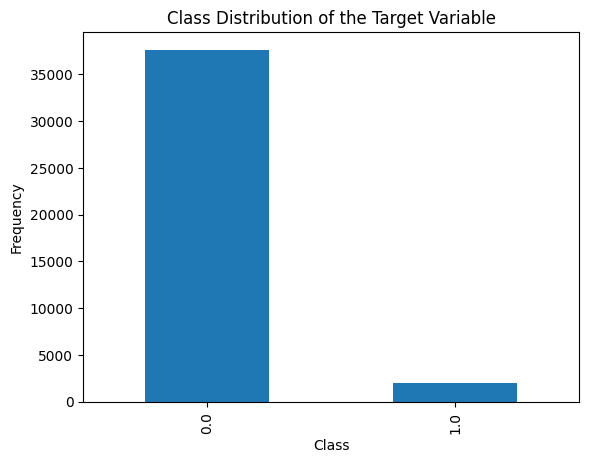

In [ ]:
target_col='ons_agreement_6'

class_distribution = df[target_col].value_counts()
print(class_distribution)

class_proportions = df[target_col].value_counts(normalize=True)
print(class_proportions)

import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.title('Class Distribution of the Target Variable')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

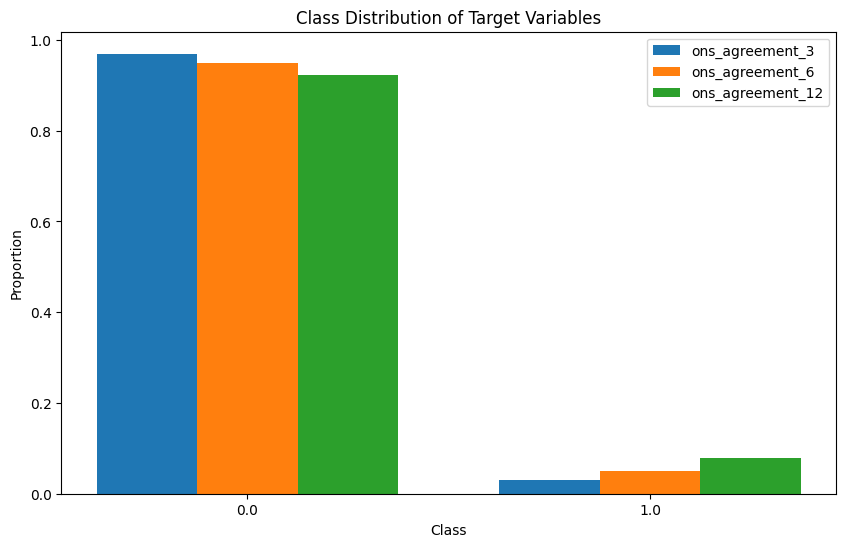

In [ ]:
targets = ['ons_agreement_3', 'ons_agreement_6', 'ons_agreement_12']
class_distributions = {target: df[target].value_counts(normalize=True) for target in targets}

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25  # Width of the bars
index = np.arange(len(class_distributions[targets[0]]))

for i, target in enumerate(targets):
    ax.bar(index + i * bar_width, class_distributions[target], width=bar_width, label=target)

# Add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Proportion')
ax.set_title('Class Distribution of Target Variables')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_distributions[targets[0]].index)
ax.legend()

# Show plot
plt.show()

We can see here that the data is heavily imbalanced as no peace agreement is expected within the next 3, 6, or 12 months. Moreover, similar to the conflict onset discussed in class, when looking at `ons_agreement_12`, the class imbalance appears slightly less severe compared to `ons_agreement_3` and `ons_agreement_6`. This can be due to the increased likelihood of a peace agreement occurring within a longer horizon. As time goes on, the likelihood of negotiations progressing or being signed into an agreement could increase.

In [ ]:
#building models
text = ['tokens'] + list(df.columns[df.columns.str.contains('theta')])
gdelt = ['avg_goldstein_scale', 'gov_related_events']
hist_ons = ['since_agreement']

features_combo = {
    'text': [*text, 'population'],
    'gdelt': gdelt,
    'hist': hist_ons,
    'all': [*text,*gdelt,*hist_ons],
}

# Drop missing values before the loop
df_clean = df.dropna(subset=features_combo['all'] + [target_col])
df_clean.reset_index(drop=True, inplace=True)

unique_periods_clean = pd.Series(df_clean['period'].unique()).sort_values()
panel_split = PanelSplit(
    unique_periods=unique_periods_clean,
    train_periods=df_clean['period'],
    n_splits=10,
    gap=1,
    test_size=1
)

print('Initalizing PanelSplit creates folds of periods. These are within self.u_periods_cv.')
for i, (train_periods, test_periods) in enumerate(panel_split.u_periods_cv):
    print(f"Fold {i}:")
    print(f"  Train: periods={train_periods}")
    print(f"  Test:  periods={test_periods}")

print(unique_periods_clean)

Initalizing PanelSplit creates folds of periods. These are within self.u_periods_cv.
Fold 0:
  Train: periods=[200501 200502 200503 200504 200505 200506 200507 200508 200509 200510
 200511 200512 200601 200602 200603 200604 200605 200606 200607 200608
 200609 200610 200611 200612 200701 200702 200703 200704 200705 200706
 200707 200708 200709 200710 200711 200712 200801 200802 200803 200804
 200805 200806 200807 200808 200809 200810 200811 200812 200901 200902
 200903 200904 200905 200906 200907 200908 200909 200910 200911 200912
 201001 201002 201003 201004 201005 201006 201007 201008 201009 201010
 201011 201012 201101 201102 201103 201104 201105 201106 201107 201108
 201109 201110 201111 201112 201201 201202 201203 201204 201205 201206
 201207 201208 201209 201210 201211 201212 201301 201302 201303 201304
 201305 201306 201307 201308 201309 201310 201311 201312 201401 201402
 201403 201404 201405 201406 201407 201408 201409 201410 201411 201412
 201501 201502 201503 201504 201505 20

In [ ]:
# Initialize logisitc regression model
model = LogisticRegression(solver='liblinear')

# Store scores
scores = []

# Manually handling splits
for train_idx, test_idx in panel_split.split():
    X_train, X_test = df_clean.iloc[train_idx][features_combo['all']], df_clean.iloc[test_idx][features_combo['all']]
    y_train, y_test = df_clean.iloc[train_idx][target_col], df_clean.iloc[test_idx][target_col]

    # Fit model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    scores.append(score)

print("Average ROC-AUC across folds:", np.mean(scores))

Average ROC-AUC across folds: 0.8657207465516704


In [ ]:
# Get the coefficients and the intercept
coefficients = model.coef_[0]  # Coefficients for the features
intercept = model.intercept_   # Intercept term

# Print the intercept
print("Intercept:", intercept)

# Match coefficients to column names and print
feature_names = X_train.columns
coefs_with_features = list(zip(feature_names, coefficients))
coefs_with_features_sorted = sorted(coefs_with_features, key=lambda x: -abs(x[1]))

# Display the coefficients alongside feature names
print("Coefficients:")
for feature, coef in coefs_with_features_sorted:
    print(f"{feature}: {coef}")

Intercept: [-1.39907326]
Coefficients:
theta_1: -0.23836014416404322
theta_11: -0.2300429335345242
theta_4: -0.19932602874437902
theta_0: -0.17639576470810575
theta_3: -0.15757726543079542
theta_7: -0.15433181945994606
theta_5: -0.14548972573239458
theta_8: -0.10772498083053857
theta_12: -0.0997405271186608
theta_9: 0.08582613052346298
theta_6: 0.06776273027486392
theta_14: -0.03923205817594097
avg_goldstein_scale: -0.037100008780351655
since_agreement: -0.03453004949569011
theta_13: 0.024018592253899462
theta_10: -0.023658281237121104
theta_2: -0.00905317608691837
tokens: 6.761497567445233e-06
gov_related_events: 5.877041528186214e-06


In [ ]:
topic_names = {
    'theta_0': 'Change',
    'theta_1': 'Cooperation',
    'theta_2': 'Defense',
    'theta_3': 'Politics',
    'theta_4': 'Economy',
    'theta_5': 'Legal Proceedings',
    'theta_6': 'Conflict Zones',
    'theta_7': 'Development Projects',
    'theta_8': 'Sports',
    'theta_9': 'Human Rights',
    'theta_10': 'Military Operations',
    'theta_11': 'Family & Social Life',
    'theta_12': 'War & International Conflict',
    'theta_13': 'Government & Policy',
    'theta_14': 'Public Health & Safety'
}

# Assuming 'coefficients' and 'feature_names' are already defined:
coefs_with_features = list(zip(feature_names, coefficients))
coefs_with_features_sorted = sorted(coefs_with_features, key=lambda x: -abs(x[1]))

# Create a DataFrame for easier handling
df_coeffs = pd.DataFrame(coefs_with_features_sorted, columns=['Feature', 'Coefficient'])

# Map the new feature names using the topic_names dictionary
df_coeffs['Feature'] = df_coeffs['Feature'].map(topic_names).fillna(df_coeffs['Feature'])

Text(0.5, 1.0, 'Feature Importance in Logistic Regression Model')

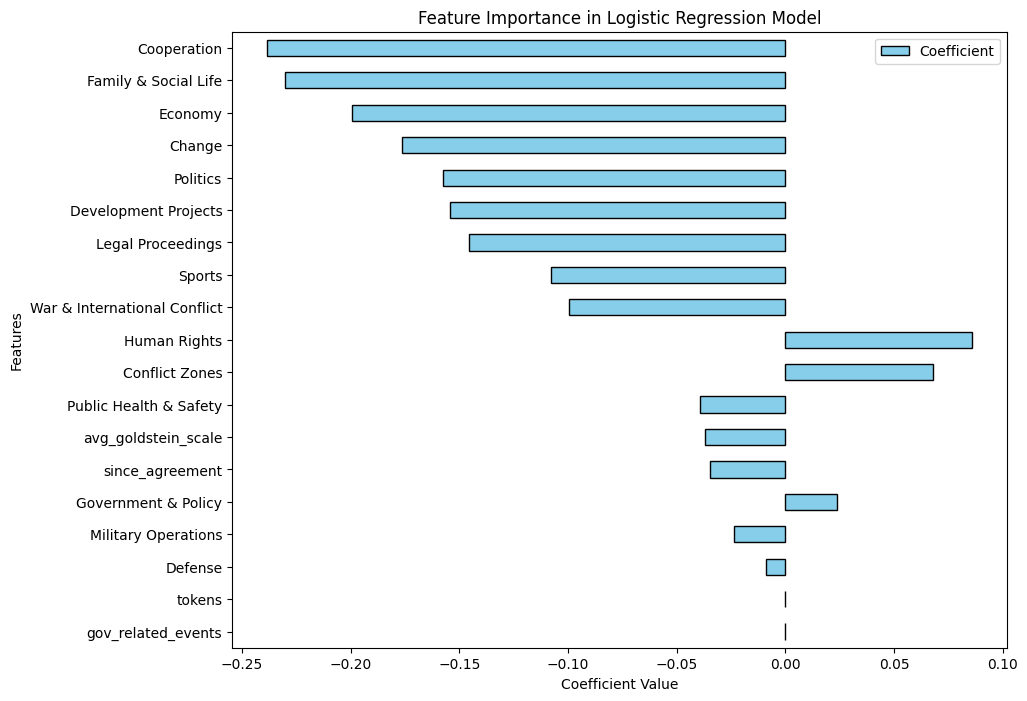

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

df_coeffs.plot(kind='barh', x='Feature', y='Coefficient', ax=ax, color='skyblue', edgecolor='black')
ax.invert_yaxis()

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Logistic Regression Model')


Based on this baseline results topics such as 'Cooperation', 'Family & Social Life', 'Economy', 'Change', 'Politics', 'Development Projects', 'Legal Proceedings', 'Sports', and 'War & International Conflict' have negative coefficients. This implies that higher representations of these topics in the text data are associated with a decrease in the likelihood of reaching a peace agreement within the specified horizon.

On the other hand, 'Human Rights', 'Conflict Zones', and 'Government & Policy' show positive coefficients, which could imply that that discussions or news articles focusing on these topics might correlate with a higher probability of approaching peace agreements. It might be that increased attention to human rights issues or discussions about government policies correlates with movements towards peace.

In this dataset, we have included the Goldstein score as can be a representation for the severity or nature of events being discussed or reported. However, the baseline results say that it has a small negative coefficient, indicating that on average, more negative actions (those with lower Goldstein scores, which reflect the potential for conflict or negativity in actions recorded in event data) are slightly predictive of lower chances of a peace agreement.

## Random Forest (Decision Trees)

After exploring the baseline model using logistic regression to predict the likelihood of peace agreements, we can further enhance our predictive capabilities by exploring more complex models. In this case, we will also use Random Forest algorithm, which can potentially provide greater accuracy and better handle the nuances and complexities inherent in the data used for forecasting peace agreements.

### Hyperparameter Tuning using GridSearch

In [ ]:
# read in the data:
df_calibrate = df.query('period < 201601')

#building models
text = ['tokens'] + list(df_calibrate.columns[df_calibrate.columns.str.contains('theta')])
gdelt = ['avg_goldstein_scale', 'gov_related_events']
hist_ons = ['since_agreement']

features_combo = {
    'text': [*text, 'population'],
    'gdelt': gdelt,
    'hist': hist_ons,
    'all': [*text,*gdelt,*hist_ons],
}

targets = ['ons_agreement_3', 'ons_agreement_6', 'ons_agreement_12']
models = {}

#loop to perform a gridsearch for each target variable
for target_col in targets:
    train = df_calibrate.dropna(subset=features_combo['all'] + [target_col]).reset_index(drop=True)
    features, target, train_periods = train[features_combo['all']], train[target_col], train['period']

    unique_sorted_periods = pd.Series(train_periods.unique()).sort_values()

    # Assuming PanelSplit is properly defined
    panel_split = PanelSplit(
        unique_periods=unique_sorted_periods,
        train_periods=train_periods,
        n_splits=10,
        gap=1,
        test_size=1
    )

    param_grid = {
        'n_estimators': [50, 100, 300],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [10, 50, 100]
    }

    param_search = GridSearchCV(
        RandomForestClassifier(),
        param_grid,
        scoring='roc_auc',
        cv=panel_split,
        n_jobs=-1,
        verbose=1
    )

    param_search.fit(features, target)

    # Store results and best model
    models[target_col] = param_search.best_estimator_

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits


In [ ]:
models

{'ons_agreement_3': RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_estimators=300),
 'ons_agreement_6': RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_estimators=300),
 'ons_agreement_12': RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_estimators=50)}

### Generate Predictions

In [ ]:
# Initialize dictionary to store predictions
predictions = {}
roc_aucs = {}
accuracies = {}

#loop to generate predictions for each target column
for target_col in targets:

  train = df.dropna(subset=features_combo['all'] + [target_col]).reset_index(drop=True)
  features, target, train_periods = train[features_combo['all']], train[target_col], train['period']

  unique_sorted_periods = pd.Series(train_periods.unique()).sort_values()

  # Assuming PanelSplit is properly defined
  panel_split = PanelSplit(
      unique_periods=unique_sorted_periods,
      train_periods=train_periods,
      n_splits=10,
      gap=1,
      test_size=1
  )

  best_params = models[target_col].get_params()

  # Generate cross-validated predictions
  predictions[target_col] = cross_val_predict(
      estimator=RandomForestClassifier(**best_params),
      X=features,
      y=target,
      indices = train[['isocode','period']],
      cv=panel_split
  )

100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


In [ ]:
predictions

{'ons_agreement_3':       isocode  period  ons_agreement_3  ons_agreement_3_pred
 187       AFG  202112              0.0              0.072988
 400       AGO  202112              0.0              0.003381
 613       ALB  202112              0.0              0.004564
 826       ARE  202112              0.0              0.003263
 1039      ARG  202112              0.0              0.004772
 ...       ...     ...              ...                   ...
 39351     YEM  202209              0.0              0.293286
 39564     YUG  202209              0.0              0.010917
 39777     ZAF  202209              0.0              0.002084
 39990     ZMB  202209              0.0              0.002361
 40200     ZWE  202209              0.0              0.002548
 
 [1909 rows x 4 columns],
 'ons_agreement_6':       isocode  period  ons_agreement_6  ons_agreement_6_pred
 184       AFG  202109              0.0              0.175884
 394       AGO  202109              0.0              0.005266
 604

In [ ]:
pred_df3 = pd.DataFrame(predictions['ons_agreement_3'])
pred_df6 = pd.DataFrame(predictions['ons_agreement_6'])
pred_df12 = pd.DataFrame(predictions['ons_agreement_12'])

In [ ]:
pred_df3.to_csv(spitout + '/pred_df_3.csv', index=False)
pred_df6.to_csv(spitout + '/pred_df_6.csv', index=False)
pred_df12.to_csv(spitout + '/pred_df_12.csv', index=False)


In [ ]:
# Calculate and print ROC-AUC
roc_auc = roc_auc_score(pred_df3['ons_agreement_3'], pred_df3['ons_agreement_3_pred'])
roc_aucs[target_col] = roc_auc  # Store ROC-AUC scores
print(f"ROC-AUC Score for ons_agreement_3: {roc_auc}")

# Calculate and print ROC-AUC
roc_auc = roc_auc_score(pred_df6['ons_agreement_6'], pred_df6['ons_agreement_6_pred'])
roc_aucs[target_col] = roc_auc  # Store ROC-AUC scores
print(f"ROC-AUC Score for ons_agreement_6: {roc_auc}")

# Calculate and print ROC-AUC
roc_auc = roc_auc_score(pred_df12['ons_agreement_12'], pred_df12['ons_agreement_12_pred'])
roc_aucs[target_col] = roc_auc  # Store ROC-AUC scores
print(f"ROC-AUC Score for ons_agreement_12: {roc_auc}")


ROC-AUC Score for ons_agreement_3: 0.8669583044583045
ROC-AUC Score for ons_agreement_6: 0.9047010771001878
ROC-AUC Score for ons_agreement_12: 0.9251971547858358


Based on the ROC-AUC and accuracy scores, the model yielded a great prediction. To further look into the model built by random forest, we are going to use several methods to visualize the model's performance.

### Model Performance

We now further assess the model's performance using some data visualization tools and other ways of analyzing the performance of a classification model.

In [ ]:
pred_df3 = pd.read_csv(spitout+ '/pred_df_3.csv')
pred_df6 = pd.read_csv(spitout+ '/pred_df_6.csv')
pred_df12 = pd.read_csv(spitout+ '/pred_df_12.csv')

In [ ]:
# Assuming predictions and df are your DataFrames
# Perform a left merge
merged_df1 = pd.merge(pred_df3, df[['isocode','period', 'tokens', 'population', 'theta_0', 'theta_1',
       'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7',
       'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13',
       'theta_14', 'any_agreement',
       'gov_related_events',
       'avg_goldstein_scale', 'since_agreement',]],
                     on=['isocode', 'period'], how='left')

merged_df2 = pd.concat([merged_df1, pred_df6[['ons_agreement_6','ons_agreement_6_pred']]], axis=1)

merged_df = pd.concat([merged_df2,pred_df12[['isocode','period','ons_agreement_12','ons_agreement_12_pred']]], axis=1)

In [ ]:
t = 0.5
# Convert probabilities to binary predictions assuming threshold of 0.5
merged_df['ons_agreement_3_binary_pred'] = (merged_df['ons_agreement_3_pred'] > t).astype(int)
merged_df['ons_agreement_6_binary_pred'] = (merged_df['ons_agreement_6_pred'] > t).astype(int)
merged_df['ons_agreement_12_binary_pred'] = (merged_df['ons_agreement_12_pred'] > t).astype(int)


In [ ]:
merged_df.to_csv(spitout + '/pred_df.csv', index=False)

In [ ]:
#Functions to make figures and save them
def draw_precision_curve(y,x,name):
    precision, recall, thresholds = precision_recall_curve(y, x)
    avprec=average_precision_score(y, x)

    plt.plot(recall, precision, lw=5, label='Av.Precision = %0.2f)' % (avprec))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision/Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(spitout+name+'.pdf')
    plt.show()

def draw_roc_curve(y,x,name):
    fpr, tpr, thresholds = roc_curve(y,x)
    roc_auc = auc(fpr, tpr)


    plt.plot(fpr,tpr, lw=5, label='AUC = %0.2f)' % (roc_auc))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower left")
    plt.savefig(spitout+name+'.pdf')
    plt.show()


def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y_true : vector of observed class labels
        y_pred : vector of predicted probabilities
        fname: file path to directory to save plot
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''
    #normalization
    pdata=(pdata-pdata.min())/(pdata.max()-pdata.min())

    #wrangling
    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]

    evals = events.index.values


    plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted Score')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])


    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'True Positives', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)

    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted Score', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    plt.savefig(fname)
    plt.show()
    plt.close()

def confmat(df,subset,preds):
  cleaned_df = df.dropna(subset=[subset])
  conf_matrix = confusion_matrix(cleaned_df[subset], cleaned_df[preds])
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Onset', 'Onset'], yticklabels=['No Onset', 'Onset'])
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()


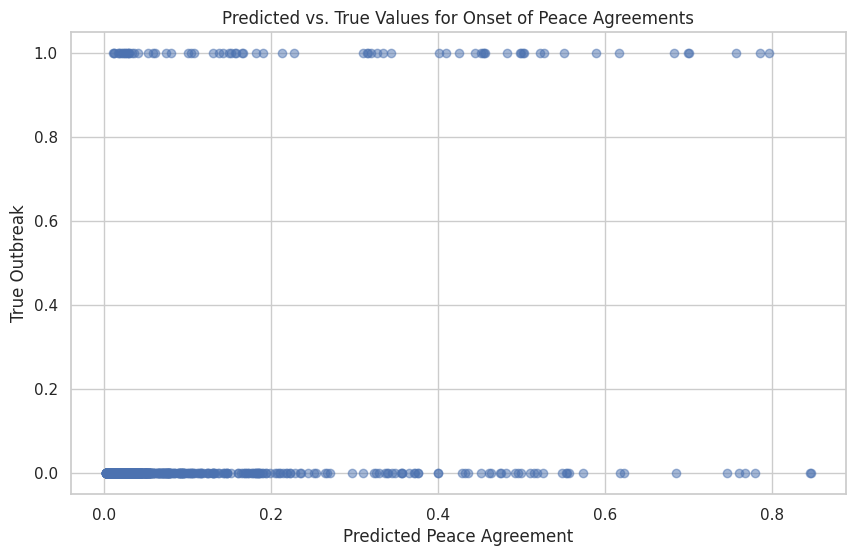

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pred_df6['ons_agreement_6_pred'], pred_df6['ons_agreement_6'], alpha=0.5)
plt.title('Predicted vs. True Values for Onset of Peace Agreements')
plt.xlabel('Predicted Peace Agreement')
plt.ylabel('True Outbreak')
plt.grid(True)
plt.show()

In this plot, it is expected the majority of true values (actual onset of peace agreements) being 0. But this result also suggests that the model is highly conservative, predicting 'no onset of peace agreement' in most cases.

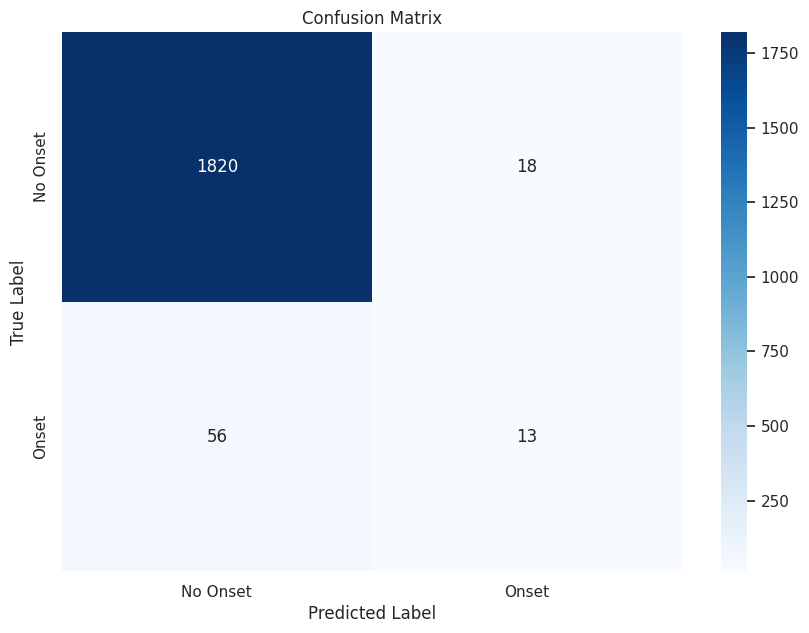

In [ ]:
# Calculate confusion matrix
confmat(merged_df,'ons_agreement_6','ons_agreement_6_binary_pred')

While the model is highly effective at predicting that there is no onset of peace agreements, with 1833 correct predictions out of 1907 cases, its performance on the onset of peace agreements raises concerns. The model correctly predicted only 13 out of 69 cases of peace agreement onset, which implies a substantial number of false negatives (56 cases). This suggests that while the model is reliable for predicting the absence of peace agreements, it struggles to identify the actual occurrences of these events.

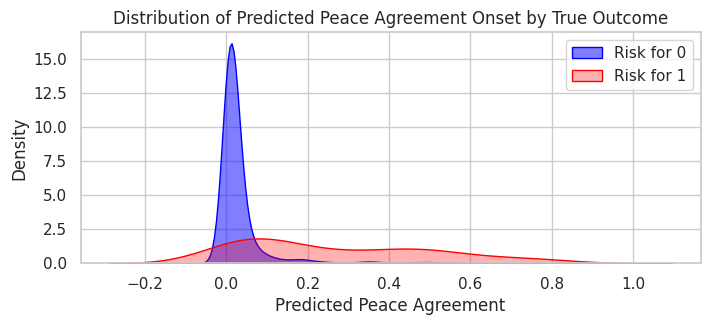

In [ ]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(8, 3))

# KDE plot for category 0 with the updated 'fill' parameter
sns.kdeplot(merged_df.loc[merged_df['ons_agreement_6'] == 0, 'ons_agreement_6_pred'], color="blue", fill=True, alpha=0.5, label='Risk for 0')

# KDE plot for category 1 with the updated 'fill' parameter
sns.kdeplot(merged_df.loc[merged_df['ons_agreement_6'] == 1, 'ons_agreement_6_pred'], color="red", fill=True, alpha=0.3, label='Risk for 1')

# Adding plot title, and x and y labels
plt.title('Distribution of Predicted Peace Agreement Onset by True Outcome')
plt.xlabel('Predicted Peace Agreement')
plt.ylabel('Density')

# Adding a legend to differentiate between categories
plt.legend()

# Show plot

Given this figure, we can say that even though the model is effective in identifying situations with a low likelihood of onset of a peace agreement, its predictive power diminishes as the probability of an onset increases. Decision-makers should therefore exercise caution and possibly seek additional information or analysis when the model predicts higher probabilities of peace agreement onsets.

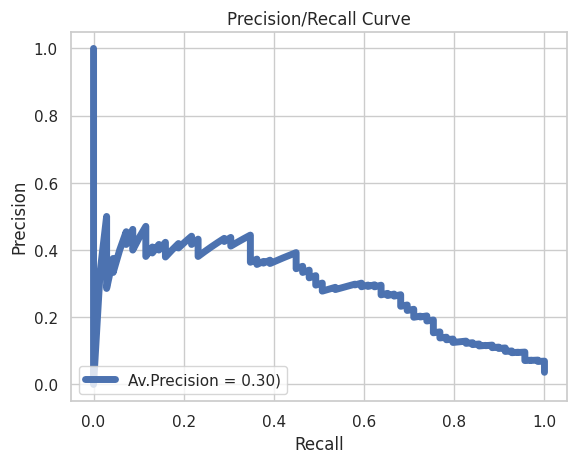

In [ ]:
# Suppose 'predictions' is your DataFrame with actual and predicted data
y_true = merged_df['ons_agreement_6'].dropna()  # Actual labels
y_scores = merged_df['ons_agreement_6_pred'].dropna()  # Predicted probabilities

# Draw Precision-Recall Curve
draw_precision_curve(y_true, y_scores, name='precision_recall_curve')

As for the precision/recall curve, now we can see here that despite the high accuracy of the model, the model just captures all the non-onset of peace agreements in country/period where the peace agreement did not occur. This also illustrates the high number of onset of peace agreement that was not captured by the model

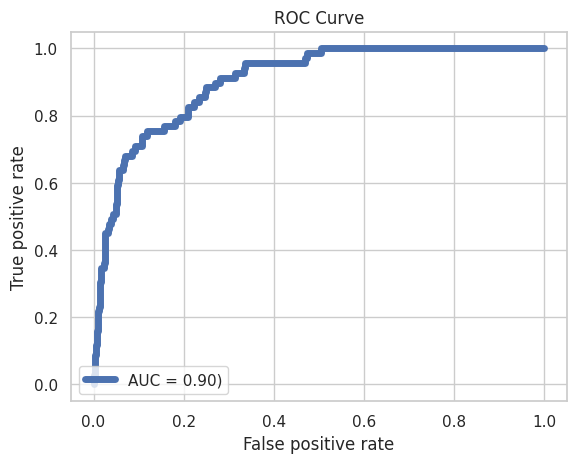

In [ ]:
# Draw ROC Curve
draw_roc_curve(y_true, y_scores, name='roc_curve')


The ROC curve depicted here exhibits an impressive Area Under Curve (AUC) of 0.90, illustrating the model's capability to distinguish between the true positives (onset of peace agreements) and true negatives.

In this ROC curve, at start, the curve rapidly climbs, suggesting that the model can achieve a high true positive rate without significantly increasing the false positive rate. Then this curve plateaus close to the top of the graph, which implies that increasing the model's sensitivity beyond a certain point only increases the true positive rate marginally.

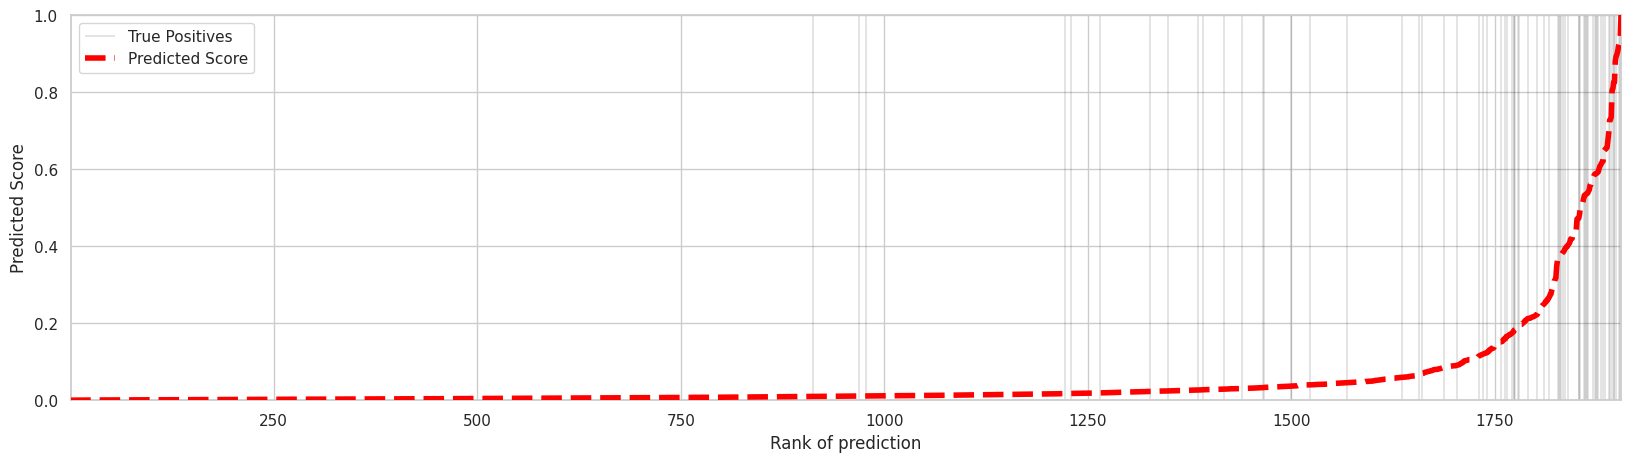

In [ ]:
# Separation Plot
# For the separation plot, you need to prepare the data as a DataFrame with correct columns as expected by the function
pdata = pd.DataFrame({
    'y': y_true,
    'yhat': y_scores
})
separation_plot(pdata, fname=spitout+'separation_plot.pdf', alpha=0.8)

To illustrate the model further, we used a separation plot and we can see that the bulk of true positives (actual onsets of peace agreements) is clustered towards the higher end of the rank of preditcion. This clustering could suggests that the model effectively identifies higher-likelihood scenarios where the onset of a peace agreement is more likely.

Now looking at the other onset value of 12:

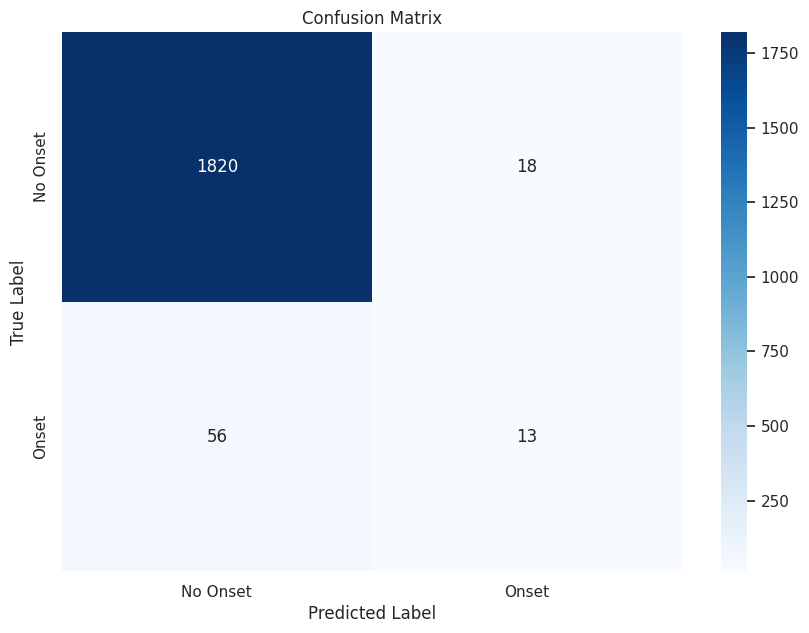

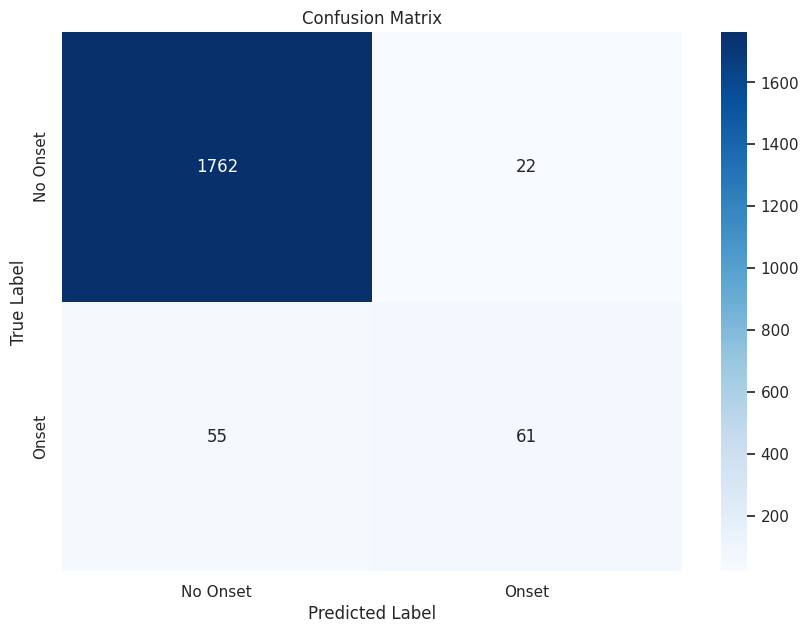

In [ ]:
confmat(merged_df,'ons_agreement_6','ons_agreement_6_binary_pred')
confmat(merged_df,'ons_agreement_12','ons_agreement_12_binary_pred')

As expected, the 12-month onset predicted better since it has a longer horizon to look at, similar to the conflict onset forecast. However, it still did not predict the onset well with only 61 peace agreements that were predicted correctly.

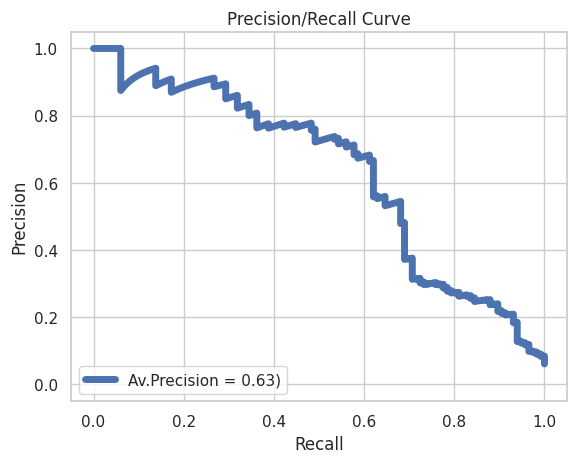

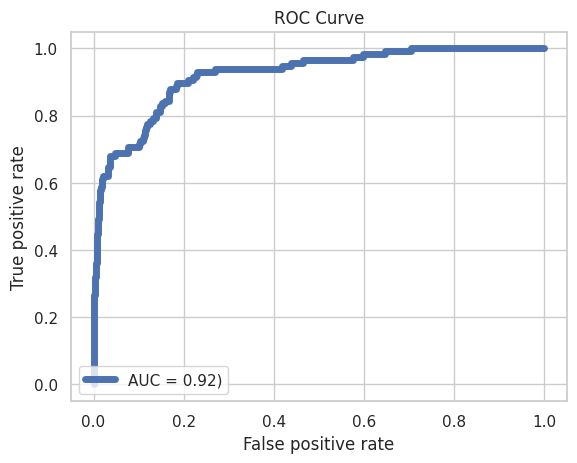

In [ ]:
# Suppose 'predictions' is your DataFrame with actual and predicted data
y_true = merged_df['ons_agreement_12'].dropna()  # Actual labels
y_scores = merged_df['ons_agreement_12_pred'].dropna()  # Predicted probabilities

draw_precision_curve(y_true, y_scores, name='precision_recall_curve')
draw_roc_curve(y_true, y_scores, name='roc_curve')

Now, looking at the precision/recall curve, the 12-month onset model definitely performed better, with a precision of 0.63. The ROC curve comparison between the 6-month onset (AUC of 0.90) and the 12-month onset (AUC of 0.92) models reveals that the 12-month onset model is more effective at discriminating between the positive and negative classes, as indicated by its higher AUC.

## Isocost Curves

Now using the onset of 6 months let us look to their isocosts:

In [ ]:
def draw_roc_curve_with_isocost(y, x, name):
    valid_indices = y.notnull()
    y, x = y[valid_indices], x[valid_indices]
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y, x)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

    # Isocost curve parameters (you can adjust these)
    Cost_FP = 2
    Cost_FN = 10
    Cost_TP = -1
    Cost_TN = 0
    Total_Cost = 200
    y = np.array(y)  # Only needed if y is not already a NumPy array

    positives = np.sum(y == 1)
    negatives = np.sum(y == 0)

    print(f"Number of positives: {positives}")
    print(f"Number of negatives: {negatives}")
    N_over_P = negatives/positives  # Ratio of negatives to positives

    # Calculating isocost line values
    fpr_values = np.linspace(0.01, 0.99, 100)  # Avoid division by zero
    tpr_values = ((Cost_FP - Cost_TN) / (Cost_FN - Cost_TP)) * N_over_P * fpr_values + ((N_over_P * Cost_TN + Cost_FN - (Total_Cost / N_over_P)) / (Cost_FN - Cost_TP))

    # Plot isocost curves
    plt.plot(fpr_values, tpr_values, 'r--', lw=2, label='Isocost curve')

    # Setting the plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Isocost Curves')
    plt.legend(loc="lower right")
    plt.savefig(spitout + name + '.pdf')
    plt.show()

Number of positives: 69
Number of negatives: 1838


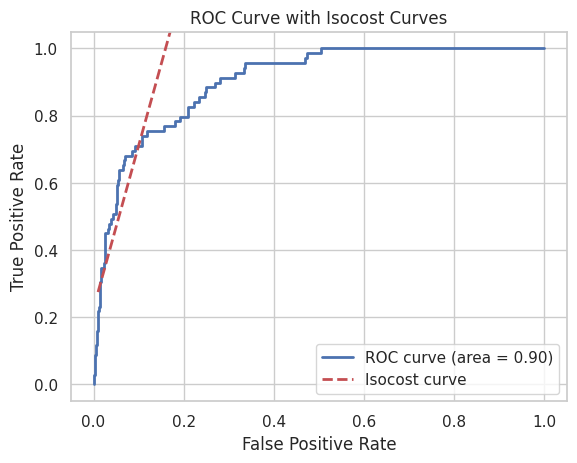

In [ ]:
draw_roc_curve_with_isocost(merged_df['ons_agreement_6'],merged_df['ons_agreement_6'+'_pred'],'roc_all_withcost'+'ons_agreement_6')

In the context of the ROC curve with isocost curves, the optimal cut-off is found at the point where the isocost curveis tangent to the ROC curve. This tangent point represents the optimal trade-off between the true positive rate and the false positive rate based on the specified cost parameters.

As for the cost of the false negative `Cost_FN` in this graph, this could reflect the serious consequences of failing to predict an actual peace agreement onset. This could include missed opportunities for peace, continuation of conflict, or other negative outcomes that could have been potentially mitigated.

On the other hand, the cost of false positives, `Cost_FP`, represents the cost incurred when the model incorrectly predicts a peace agreement onset. This might involve wasted resources, preparation, or diplomatic efforts that may be deemed as unnecessary.

# Cost Model Adaptation
In this context, policymakers and diplomatic institutions such as the UN would want to minimize expected total costs by choosing a forecast cutoff $c$. This can be formalized using this cost minimization problem:
$\min E[cost_c] = cost_{TP} \times E[TP_c] + cost_{FP} \times E[FP_c] + cost_{FN} \times E[FN_c] + cost_{TN} \times E[TN_c]$

In here, we are assuming the following:
  - Forecast Reliabilty: Out-of-sample performance in the past can serve as our benchmark and we assume it to be reliable, which implies that the policymakers in the past will still use the same criteria or conditions in the future when they are making decisions on when to implement a peace agreement
  - Cost of Peace Efforts:
    - For true positives, successful predictions and the subsequent intervention (diplomatic efforts) incur both cost *I* and benefits, future cost of peace $V_p$.
    - For False positives, unnecessary intervention incur direct costs *I* and some potentially wasted resources, but could possibly contribute to peace stability $V_p$
  - Effectiveness and Intervention: We assume a likelihood constant $p$ that an intervention following prediction will be successful in facilitating a peace agreement.
  - True negatives assume no direct costs ( *I*) associated with true negatives, as it is just the status quo. Here, no peace agreement is predicted nor is it needed. However, maintaining status quo (or ongoing peace efforts) should contribute to future peace.

  Following the minimization problem earlier, our function will now look like the following:
  $\min_c E[cost_c] = (pV_p + (1-p)V_D + I) \times E[TP_c] + (V_p + I) \times E[FP_c] + V_D \times E[TN_c] + V_p \times E[TN_c]$

Given the complex aspects of these scenarios, we can be challenging as lives cannot be quantified. However, we can still assume some properties about these variables:
- $V_p = -100$ is a negative number since it is the present value of the *benefit* from having a peace agreement
- $V_D = 300$ is a positive number since it represents the total costs of a conflict such as loss of lives and damages to properties
- $|V_p| < |V_D|$ as the damages brought by conflict are still greater than the benefits of peace after a conflict. This would imply that if a conflict continues, the value of damages brought by another day of conflict is greater than the value of benefit of an immediate peace agreement.
- $I = 90$ we set to a positive number because facilitationg peace agreement could be costly because both parties need to compromise and there could also be costs when bigger countries such as the U.S. are involved.
- $p = 0.75$ we set to 75% effectiveness of peace agreements because it may be possible that not all parties involved in negotitations of peace agreements come to consensus.

Given these assumptions and the values we have assigned to each variable, we can now calculate the expected values of true positives, false positives, false negatives, and true negatives for each threshold level, plug these into the minimization function and find the optimal cut-off where costs are minimized.




In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/MasterProject/02 Data/data/pred_df.csv')
df.dropna(subset=['ons_agreement_12_pred'], inplace=True)
df.head()

,isocode,period,ons_agreement_3,ons_agreement_3_pred,tokens,population,theta_0,theta_1,theta_2,theta_3,...,since_agreement,ons_agreement_6,ons_agreement_6_pred,isocode.1,period.1,ons_agreement_12,ons_agreement_12_pred,ons_agreement_3_binary_pred,ons_agreement_6_binary_pred,ons_agreement_12_binary_pred
0,AFG,202112,0.0,0.070794,41299.0,38041754.0,0.116832,0.089725,0.084907,0.029680,...,22,0.0,0.214246,AFG,202103.0,0.0,0.513137,0,0,1
1,AGO,202112,0.0,0.004224,88.0,31825295.0,0.076945,0.152676,0.012525,0.069166,...,204,0.0,0.004915,AGO,202103.0,0.0,0.013462,0,0,0
2,ALB,202112,0.0,0.005656,2067.0,2854191.0,0.110736,0.105852,0.027597,0.109898,...,204,0.0,0.009752,ALB,202103.0,0.0,0.016615,0,0,0
3,ARE,202112,0.0,0.005747,2424.0,9770529.0,0.121465,0.148596,0.042508,0.041955,...,204,0.0,0.008777,ARE,202103.0,0.0,0.018438,0,0,0
4,ARG,202112,0.0,0.003094,5826.0,44938712.0,0.111973,0.054214,0.023523,0.190375,...,204,0.0,0.007320,ARG,202103.0,0.0,0.010071,0,0,0


In [ ]:
probabilities = df['ons_agreement_6_pred']
actual_labels = df['ons_agreement_6']

thresholds = np.linspace(0, 1, 11)
print(thresholds)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:
#to store results
results = []

# loop to iterate over each threshold
for threshold in thresholds:
    #convert probabilities to binary predictions based on the current threshold
    predictions = (probabilities >= threshold).astype(int)

    #calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(actual_labels, predictions).ravel()

    #append results
    results.append({
        'Threshold': threshold,
        'E[TP]': tp,
        'E[FP]': fp,
        'E[FN]': fn,
        'E[TN]': tn
    })

#convert to DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

    Threshold  E[TP]  E[FP]  E[FN]  E[TN]
0         0.0     69   1831      0      0
1         0.1     47    128     22   1703
2         0.2     33     67     36   1764
3         0.3     31     48     38   1783
4         0.4     24     31     45   1800
5         0.5     13     18     56   1813
6         0.6      7      9     62   1822
7         0.7      3      6     66   1825
8         0.8      0      2     69   1829
9         0.9      0      0     69   1831
10        1.0      0      0     69   1831


In [ ]:
#variables in the cost function
V_P = -100  #benefits of peace
V_D = 300  #cost of conflict
I = 90     #intervention cost
p = 0.75    #probability of successful peace agreement facilitation

#calculate the expected total cost for each threshold using our function from above
results_df['Expected Cost'] = ((p * V_P + (1 - p) * V_D + I) * results_df['E[TP]'] +
                       (V_P + I) * results_df['E[FP]'] +
                       V_D * results_df['E[FN]'] +
                       V_P * results_df['E[TN]'])

#to find the optimal threshold we look for the minimum cost
optimal_index = results_df['Expected Cost'].idxmin()
optimal_threshold = results_df.loc[optimal_index, 'Threshold']
optimal_cost = results_df.loc[optimal_index, 'Expected Cost']

print(f"Optimal threshold: {optimal_threshold}")
print(f"Cost at optimal threshold: {optimal_cost}")
print(results_df[['Threshold', 'Expected Cost']])

Optimal threshold: 0.4
Cost at optimal threshold: -164650.0
    Threshold  Expected Cost
0         0.0       -12100.0
1         0.1      -160750.0
2         0.2      -163300.0
3         0.3      -164590.0
4         0.4      -164650.0
5         0.5      -163510.0
6         0.6      -163060.0
7         0.7      -162490.0
8         0.8      -162220.0
9         0.9      -162400.0
10        1.0      -162400.0


Now based on this result, we can set our optimal cut-off to 0.4 which is lower than earlier value. Aside from capturing more onsets, this lower threshold also implies that the policy decision makers need not to look too much when deciding when to implement a peace agreement as the cost of conflict is still much higher.